# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

**Содержание:**  
<a id="start"></a>
1. [Импорт данных и общая информация](#section_1)  
 1.1. [Импорт библиотек](#section_1_1)  
 1.2. [Импорт данных](#section_1_2)  
 1.3. [Общая информация](#section_1_3)  
    
    
2. [Предобработка и исследовательский анализ данных](#section_2)  
 2.1. [Предобработка данных](#section_2_1)  
 2.2. [Исследовательский анализ данных](#section_2_2)
 
 
3. [Вычисление бизнес-метрики](#section_3)  


4. [Разработка модели ML](#section_4)  
 4.1. [Подготовка данных](#section_4_1)  
 4.2. [Построение моделей и определение лучшей](#section_4_2)  

5. [Проверка на тестовой выборке](#section_5)

6. [Прогноз прибыли](#section_6)
 6.1. [Проверка гипотезы об увеличении прибыли](#section_6_1)  
 
 
7. [Признаки «ненадёжного» клиента](#section_7)  

8. [Общий вывод](#section_8)

**Заказчик исследования:** сеть отелей.  
**Цель исследования:** построить модель прогнозирования отмены бронирования клиентами с целью внедрения для таковых и списания депозита в случае снятия брони.

**Особенности проекта:**  
Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку.  
В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.  
Стоимость номеров отеля:
- категория A: за ночь — 1 000, разовое обслуживание — 400;  
- категория B: за ночь — 800, разовое обслуживание — 350;  
- категория C: за ночь — 600, разовое обслуживание — 350;  
- категория D: за ночь — 550, разовое обслуживание — 150;  
- категория E: за ночь — 500, разовое обслуживание — 150;  
- категория F: за ночь — 450, разовое обслуживание — 150;  
- категория G: за ночь — 350, разовое обслуживание — 150.  

В ценовой политике отеля используются сезонные коэффициенты:  
- весной и осенью цены повышаются на 20%;  
- летом — на 40%.  

Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.  
На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше прибыли, которую система принесёт компании.

**Исходные данные:**  
Исходные данные представлены в датасетах:
- hotel_train.csv — данные для обучения модели;
- hotel_test.csv — данные для тестирования модели.

В датасетах содержатся следующие признаки:  
- id — номер записи;  
- adults — количество взрослых постояльцев;  
- arrival_date_year — год заезда;  
- arrival_date_month — месяц заезда;  
- arrival_date_week_number — неделя заезда;  
- arrival_date_day_of_month — день заезда;  
- babies — количество младенцев;  
- booking_changes — количество изменений параметров заказа;  
- children — количество детей от 3 до 14 лет;  
- country — гражданство постояльца;  
- customer_type — тип заказчика:  
  Contract — договор с юридическим лицом;  
  Group — групповой заезд;  
  Transient — не связано с договором или групповым заездом;  
  Transient-party — не связано с договором или групповым заездом, но связано с бронированием типа Transient.  
- days_in_waiting_list — сколько дней заказ ожидал подтверждения;  
- distribution_channel — канал дистрибуции заказа;  
- is_canceled — отмена заказа;  
- is_repeated_guest — признак того, что гость бронирует номер второй раз;  
- lead_time — количество дней между датой бронирования и датой прибытия;  
- meal — опции заказа:  
  SC — нет дополнительных опций;  
  BB — включён завтрак;  
  HB — включён завтрак и обед;  
  FB — включён завтрак, обед и ужин.  
- previous_bookings_not_canceled — количество подтверждённых заказов у клиента;  
- previous_cancellations — количество отменённых заказов у клиента;  
- required_car_parking_spaces — необходимость места для автомобиля;  
- reserved_room_type — тип забронированной комнаты;  
- stays_in_weekend_nights — количество ночей в выходные дни;  
- stays_in_week_nights — количество ночей в будние дни;  
- total_nights — общее количество ночей;  
- total_of_special_requests — количество специальных отметок.  

## Импорт данных и общая информация
<a id="section_1"></a>

### Импорт библиотек
<a id="section_1_1"></a>

In [1]:
import datetime as dt
import math
import timeit

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
from imblearn.pipeline import Pipeline
from numpy import argmax
from numpy import sqrt
from scipy import stats as st
from scipy.stats import levene, spearmanr
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.metrics import recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from optuna.distributions import FloatDistribution as floatd
from optuna.distributions import IntDistribution as intd
import optuna
from optuna.integration import OptunaSearchCV

### Импорт данных
<a id="section_1_2"></a>

In [2]:
df_train = pd.read_csv('hotel_train.csv')
df_test = pd.read_csv('hotel_test.csv')

### Общая информация
<a id="section_1_3"></a>

Функция вывода общей информации:

In [3]:
object_list = ['arrival_date_month', 'meal', 'distribution_channel', 'reserved_room_type', 'customer_type', 'country']

def inf(df_info):
    print()
    print('Общая информация:')
    display(df_info.info(memory_usage='deep'))
    print('_' * 50)
    print()
    print('Уникальные значения строковых признаков:')
    for i in object_list:
        print('{}:'.format(i))
        print(df_info[i].unique())
        print()
    print('Описательная статистика строковых значений:')
    display(df_info.describe(include='object').T)
    print('_' * 50)
    print()
    print('Описательная статистика числовых значений:')
    display(df_info.describe().T)
    print('_' * 50)
    print()
    print('Процент пропущенных значений:')
    display(df_info.isna().mean()*100)
    print('_' * 50)
    print()
    print('Случайная выборка датафрейма:')
    display(df_info.sample(n = 5, random_state = 0))
    print('_' * 100)

Общая информация по обучающим данным:

In [4]:
inf(df_train)


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal         

None

__________________________________________________

Уникальные значения строковых признаков:
arrival_date_month:
['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']

meal:
['BB       ' 'FB       ' 'HB       ' 'SC       ' 'SC']

distribution_channel:
['Direct' 'TA/TO' 'Corporate' 'GDS']

reserved_room_type:
['A               ' 'C               ' 'D               '
 'E               ' 'G               ' 'F               '
 'B               ']

customer_type:
['Transient' 'Contract' 'Transient-Party' 'Group']

country:
['GBR' 'PRT' 'ESP' 'IRL' 'FRA' 'ROU' 'NOR' 'USA' 'DEU' 'BEL' 'CHE' 'CN'
 'GRC' 'NLD' 'ARG' 'RUS' 'SWE' 'POL' 'EST' 'CZE' 'ITA' 'FIN' 'DNK' 'MOZ'
 'BWA' 'LUX' 'BRA' 'SVN' 'ALB' 'CHN' 'MEX' 'MAR' 'SMR' 'LVA' 'CHL' 'AUT'
 'LTU' 'TUR' 'ISR' 'IND' 'CYM' 'AUS' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN'
 'TUN' 'ARE' 'HRV' 'HKG' 'IRN' 'GIB' 'JEY' 'URY' 'ZAF' 'COL' 'GGY' 'KWT'
 'CYP' 'KAZ' 'THA' 'DOM' 'NGA' 'BLR' 'VEN' 'UKR' 'ARM

,count,unique,top,freq
arrival_date_month,65229,12,October,9255
meal,65229,5,BB,51697
country,65229,155,PRT,28831
distribution_channel,65229,4,TA/TO,54454
reserved_room_type,65229,7,A,50501
customer_type,65229,4,Transient,45493


__________________________________________________

Описательная статистика числовых значений:


,count,mean,std,min,25%,50%,75%,max
id,65229.0,43544.069172,25614.858971,0.0,19108.0,40554.0,67414.0,84121.0
is_canceled,65229.0,0.368609,0.482431,0.0,0.0,0.0,1.0,1.0
lead_time,65229.0,96.337917,96.127545,0.0,17.0,64.0,151.0,374.0
arrival_date_year,65229.0,2015.719021,0.449481,2015.0,2015.0,2016.0,2016.0,2016.0
arrival_date_week_number,65229.0,31.339772,13.464024,1.0,21.0,34.0,42.0,53.0
arrival_date_day_of_month,65229.0,15.847813,8.748182,1.0,8.0,16.0,23.0,31.0
stays_in_weekend_nights,65229.0,0.825185,0.853477,0.0,0.0,1.0,2.0,4.0
stays_in_week_nights,65229.0,2.224793,1.354992,0.0,1.0,2.0,3.0,6.0
adults,65229.0,1.836576,0.480245,0.0,2.0,2.0,2.0,4.0
children,65229.0,0.074890,0.334243,0.0,0.0,0.0,0.0,3.0


__________________________________________________

Процент пропущенных значений:


id                                0.0
is_canceled                       0.0
lead_time                         0.0
arrival_date_year                 0.0
arrival_date_month                0.0
arrival_date_week_number          0.0
arrival_date_day_of_month         0.0
stays_in_weekend_nights           0.0
stays_in_week_nights              0.0
adults                            0.0
children                          0.0
babies                            0.0
meal                              0.0
country                           0.0
distribution_channel              0.0
is_repeated_guest                 0.0
previous_cancellations            0.0
previous_bookings_not_canceled    0.0
reserved_room_type                0.0
booking_changes                   0.0
days_in_waiting_list              0.0
customer_type                     0.0
required_car_parking_spaces       0.0
total_of_special_requests         0.0
total_nights                      0.0
dtype: float64

__________________________________________________

Случайная выборка датафрейма:


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
41360,59750,0,7.0,2015,October,41,7,0,3,2.0,...,0,0,0,A,0,0,Contract,0,2,3
37015,55370,1,286.0,2015,July,31,30,0,2,2.0,...,1,1,0,A,0,0,Transient-Party,0,0,2
10616,13167,0,17.0,2016,March,10,3,0,1,2.0,...,0,0,0,A,1,0,Transient,0,0,1
6456,8807,1,152.0,2015,July,29,18,2,6,2.0,...,0,1,0,A,1,0,Contract,0,1,8
24406,32346,1,10.0,2016,March,12,17,0,2,2.0,...,0,0,0,A,0,0,Transient,0,0,2


____________________________________________________________________________________________________


1. В датафрейме 65229 строк и 25 признаков. Пропущенные значения отсутствуют.  
2. Следующие признаки имеют тип int64:  
 - id;  
 - is_canceled;  
 - arrival_date_year;  
 - arrival_date_week_number;   
 - arrival_date_day_of_month;  
 - stays_in_weekend_nights;   
 - stays_in_week_nights;    
 - is_repeated_guest;  
 - previous_cancellations;   
 - previous_bookings_not_canceled;   
 - booking_changes;  
 - days_in_waiting_list;  
 - required_car_parking_spaces;    
 - total_of_special_requests;  
 - total_nights.  
 
 Следующие признаки имеют тип object:  
  - arrival_date_month;   
  - meal;    
  - country;   
  - distribution_channel;    
  - reserved_room_type;   
  - customer_type.   

 Следующие признаки имеют тип float64:  
  - lead_time;   
  - adults;   
  - children;   
  - babies.   
  
  
3. В датафрейме приведены данные за 2015-2016 годы.  
4. Признак meal имеет пять уникальных значений, при том, что в исходных данных обозначены только 4.
5. Максимальное значение признака babies - 10 (количество младенцев), что маловероятно в реальности.
6. Запись значений признаков meal и reserved_room_type некорректны: присутствуют лишние пробелы.

Общая информация по тестовым данным:

In [5]:
inf(df_test)


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal         

None

__________________________________________________

Уникальные значения строковых признаков:
arrival_date_month:
['January' 'February' 'March' 'April' 'May' 'June' 'July' 'August']

meal:
['BB       ' 'HB       ' 'SC' 'FB       ' 'SC       ']

distribution_channel:
['TA/TO' 'Direct' 'Corporate' 'GDS']

reserved_room_type:
['A               ' 'E               ' 'G               '
 'D               ' 'F               ' 'C               '
 'B               ']

customer_type:
['Transient' 'Transient-Party' 'Contract' 'Group']

country:
['PRT' 'AUT' 'BEL' 'DEU' 'BRA' 'GBR' 'ESP' 'FRA' 'ITA' 'LUX' 'CHE' 'EST'
 'NGA' 'IRL' 'CN' 'POL' 'AUS' 'NLD' 'KOR' 'ROU' 'USA' 'CHL' 'DNK' 'FIN'
 'RUS' 'SWE' 'HUN' 'HRV' 'MDV' 'ZAF' 'ISR' 'NOR' 'CHN' 'ARE' 'MAR' 'COL'
 'FJI' 'LVA' 'LBN' 'PHL' 'HKG' 'SYC' 'GIB' 'AGO' 'MYS' 'MDG' 'IDN' 'LTU'
 'ISL' 'TUR' 'ARG' 'JPN' 'SVN' 'SVK' 'BGR' 'CAF' 'JAM' 'UZB' 'UKR' 'IND'
 'CZE' 'URY' 'NZL' 'NPL' 'SRB' 'CPV' 'IRN' 'KAZ' 'BHS' 'SUR' 'CUB' 'PAK'
 'MAC' 'CYP' 'JOR' 'GRC' 

,count,unique,top,freq
arrival_date_month,32412,8,May,5262
meal,32412,5,BB,24684
country,32412,143,PRT,9887
distribution_channel,32412,4,TA/TO,27083
reserved_room_type,32412,7,A,23471
customer_type,32412,4,Transient,27461


__________________________________________________

Описательная статистика числовых значений:


,count,mean,std,min,25%,50%,75%,max
id,32412.0,60131.505183,29953.586177,6086.0,45291.75,53394.5,89800.25,97903.0
is_canceled,32412.0,0.388467,0.487409,0.0,0.00,0.0,1.00,1.0
lead_time,32412.0,97.587869,86.507146,0.0,23.00,76.0,155.00,373.0
arrival_date_year,32412.0,2017.000000,0.000000,2017.0,2017.00,2017.0,2017.00,2017.0
arrival_date_week_number,32412.0,17.804054,9.177384,1.0,10.00,18.0,25.00,35.0
arrival_date_day_of_month,32412.0,15.656948,8.766429,1.0,8.00,15.5,23.00,31.0
stays_in_weekend_nights,32412.0,0.867888,0.853394,0.0,0.00,1.0,2.00,4.0
stays_in_week_nights,32412.0,2.340090,1.375170,0.0,1.00,2.0,3.00,6.0
adults,32412.0,1.858602,0.489341,0.0,2.00,2.0,2.00,4.0
children,32412.0,0.083765,0.343470,0.0,0.00,0.0,0.00,3.0


__________________________________________________

Процент пропущенных значений:


id                                0.0
is_canceled                       0.0
lead_time                         0.0
arrival_date_year                 0.0
arrival_date_month                0.0
arrival_date_week_number          0.0
arrival_date_day_of_month         0.0
stays_in_weekend_nights           0.0
stays_in_week_nights              0.0
adults                            0.0
children                          0.0
babies                            0.0
meal                              0.0
country                           0.0
distribution_channel              0.0
is_repeated_guest                 0.0
previous_cancellations            0.0
previous_bookings_not_canceled    0.0
reserved_room_type                0.0
booking_changes                   0.0
days_in_waiting_list              0.0
customer_type                     0.0
required_car_parking_spaces       0.0
total_of_special_requests         0.0
total_nights                      0.0
dtype: float64

__________________________________________________

Случайная выборка датафрейма:


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
18428,80470,0,3.0,2017,May,19,8,1,2,1.0,...,1,0,1,D,0,0,Transient,0,1,3
74,6162,1,3.0,2017,January,3,19,0,1,1.0,...,0,0,0,A,0,0,Transient-Party,0,2,1
416,6509,1,312.0,2017,March,10,5,2,5,2.0,...,0,0,0,A,0,0,Transient-Party,0,0,7
9472,46661,1,17.0,2017,February,9,28,0,4,2.0,...,0,0,0,A,0,0,Transient,0,0,4
6814,23769,0,251.0,2017,June,26,26,1,3,2.0,...,0,0,0,D,0,0,Transient-Party,0,0,4


____________________________________________________________________________________________________


1. В датафрейме 32412 строк и 25 признаков. Пропущенные значения отсутствуют.  
2. Следующие признаки имеют тип int64:  
 - id;  
 - is_canceled;  
 - arrival_date_year;  
 - arrival_date_week_number;   
 - arrival_date_day_of_month;  
 - stays_in_weekend_nights;   
 - stays_in_week_nights;    
 - is_repeated_guest;  
 - previous_cancellations;   
 - previous_bookings_not_canceled;   
 - booking_changes;  
 - days_in_waiting_list;  
 - required_car_parking_spaces;    
 - total_of_special_requests;  
 - total_nights.  
 
 Следующие признаки имеют тип object:  
  - arrival_date_month;   
  - meal;    
  - country;   
  - distribution_channel;    
  - reserved_room_type;   
  - customer_type.   

 Следующие признаки имеют тип float64:  
  - lead_time;   
  - adults;   
  - children;   
  - babies.   
  
  
3. В датафрейме приведены данные за январь-август 2017 года.
4. Признак meal имеет пять уникальных значений, при том, что в исходных данных обозначены только 4.
5. Запись значений признаков meal и reserved_room_type некорректны: присутствуют лишние пробелы.

**Вывод:**  
1. Датафреймы имеют следующие размеры:
 - обучающая выборка: 65229 строк и 25 признаков. Пропущенные значения отсутствуют.  
 - тестовая выборка: 32412 строк и 25 признаков. Пропущенные значения отсутствуют.  
2. Следующие признаки имеют тип int64:  
 - id;  
 - is_canceled;  
 - arrival_date_year;  
 - arrival_date_week_number;   
 - arrival_date_day_of_month;  
 - stays_in_weekend_nights;   
 - stays_in_week_nights;    
 - is_repeated_guest;  
 - previous_cancellations;   
 - previous_bookings_not_canceled;   
 - booking_changes;  
 - days_in_waiting_list;  
 - required_car_parking_spaces;    
 - total_of_special_requests;  
 - total_nights.  
 
 Следующие признаки имеют тип object:  
  - arrival_date_month;   
  - meal;    
  - country;   
  - distribution_channel;    
  - reserved_room_type;   
  - customer_type.   

 Следующие признаки имеют тип float64:  
  - lead_time;   
  - adults;   
  - children;   
  - babies.   
  
  
3. В обучающей выборке приведены данные за 2015-2016 годы, в тестовой - январь-август 2017 года.
4. Признак meal имеет пять уникальных значений, при том, что в исходных данных обозначены только 4.
5. Максимальное значение признака babies в обучающей выборке - 10 (количество младенцев), что маловероятно в реальности.
6. Запись значений признаков meal и reserved_room_type некорректны: присутствуют лишние пробелы.

[Вернуться к содержанию](#start) 

## Предобработка и исследовательский анализ данных
<a id="section_2"></a>

### Предобработка данных
<a id="section_2_1"></a>

**Обработка дубликатов**

Проверяем на дубликаты:

In [6]:
print('Количество дубликатов в обучающей выборке с учетом id: {} ({:.2%}).'.format(df_train.duplicated().sum(),
                                                                               df_train.duplicated().sum() / df_train.shape[0]))
print('Количество дубликатов в тестовой выборке с учетом id: {} ({:.2%}).'.format(df_test.duplicated().sum(),
                                                                               df_test.duplicated().sum() / df_test.shape[0]))

Количество дубликатов в обучающей выборке с учетом id: 0 (0.00%).
Количество дубликатов в тестовой выборке с учетом id: 0 (0.00%).


Удаляем столбец id и проверяем датафреймы на дубликаты:

In [7]:
df_train = df_train.drop(['id'], axis=1)
df_test = df_test.drop(['id'], axis=1)
print('Количество дубликатов в обучающей выборке без учета id: {} ({:.2%}).'.format(df_train.duplicated().sum(),
                                                                               df_train.duplicated().sum() / df_train.shape[0]))
print('Количество дубликатов в тестовой выборке без учета id: {} ({:.2%}).'.format(df_test.duplicated().sum(),
                                                                               df_test.duplicated().sum() / df_test.shape[0]))

Количество дубликатов в обучающей выборке без учета id: 21377 (32.77%).
Количество дубликатов в тестовой выборке без учета id: 7717 (23.81%).


В выборках присутствует большое количество дубликатов. Это может быть вызвано алгоритмом сбора информации при бронировании. Например, может присваиваться новый id при изменении какого либо параметра. Пользователь по каким-либо причинам может менять какой-либо параметр и возвращаться к исходному.

**Предобработка признака babies обучающей выборки**

Находим количество уникальных значений признака babies в обучающей выборке:

In [8]:
df_train['babies'].value_counts()

babies
0.0     64777
1.0       447
2.0         3
10.0        1
9.0         1
Name: count, dtype: int64

Значения 9 и 10 - выбросы. Если значение параметра больше 2, заменяем его на медиану:

In [9]:
df_train.loc[df_train['babies'] > 2, 'babies'] = df_train['babies'].median()

**Предобработка строковых значений**

Приводим строковые значения к нижнему регистру и удаляем пробелы:

In [10]:
# функция приведения строковых признаков к нижнему регистру и удаления пробелов
def remove_space(field):
    field = field.strip().lower()
    return(field)

In [11]:
for i in object_list:
    df_train[i] = df_train.apply(lambda x: remove_space(x[i]),axis=1)
    df_test[i] = df_test.apply(lambda x: remove_space(x[i]),axis=1)

**Оптимизация типов данных**

Оптимизируем типы данных:

In [12]:
# Функция преобразования типов данных
def change_type(df):
    list_uint8 = ['is_canceled', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights',
                  'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations',
                  'previous_bookings_not_canceled', 'booking_changes', 'required_car_parking_spaces',
                  'total_of_special_requests','total_nights']
    list_uint16 = ['lead_time', 'arrival_date_year', 'days_in_waiting_list']
    df[list_uint8] = df[list_uint8].astype('uint8')
    df[list_uint16] = df[list_uint16].astype('uint16')
    return df

In [13]:
df_train = change_type(df_train)
df_test = change_type(df_test)

### Исследовательский анализ данных
<a id="section_2_2"></a>

**Гистограммы распределения**

Строим гистограммы распределения признаков обучающей и тестовых выборок с разделением на отмененную и неотмененную бронь.
Из данных по дате бронирования рассматриваем только месяц: данный период достаточно велик, чтобы не учитывать случайные локальные экстремумы, и достаточно показателен для определения сезонности.

In [14]:
# функция построения гистограмм распределения признаков обучающей и тестовых выборок
# с разделением на отмененную и неотмененную бронь

def histogr(df_train, df_test):
    analisys_list = df_train.columns                             # получаем список признаков
    for i in df_train.drop(['arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month'], axis=1).columns:
        x_value = []
        if i != 'is_canceled':
            if df_train[i].nunique() < 50:
                x_value = [(i) for i in range(0, df_train[i].nunique())]
            else:
                x_value = [(i) for i in range(0, df_train[i].nunique(), 20)]
            plt.figure(figsize=(14,8))
            ax = plt.subplot(1, 2, 1)
            print(i)
            ax = sns.histplot(x=i, data=df_train, hue='is_canceled', discrete=True)
            if (i == 'country') | (i == 'arrival_date_month'):
                ax = sns.histplot(x=i, data=df_train, hue='is_canceled', discrete=True)
            else:
                ax = sns.histplot(x=i, data=df_train.sort_values(by=i), hue='is_canceled', discrete=True)
            ax.set_xticks(x_value)
            ax.set_title(f'Распределение признака {i}\n для обучающей выборки')
            ax.set_ylabel('Количество')
            ax.set_xlabel(i)
            if i == 'lead_time':
                ax.set_xlim([-20, df_train[i].nunique()])
            else:
                ax.set_xlim([-1, df_train[i].nunique()])
            if i == 'country':
                ax1.set(xticklabels=[])
            if i == 'country':
                ax.set(xticklabels=[])
            plt.xticks(rotation=45)
            
            ax1 = plt.subplot(1, 2, 2)
            if (i == 'country') | (i == 'arrival_date_month'):
                ax1 = sns.histplot(x=i, data=df_test, hue='is_canceled', discrete=True)
            else:
                ax1 = sns.histplot(x=i, data=df_test.sort_values(by=i), hue='is_canceled', discrete=True)
            ax1.set_xticks(x_value)
            ax1.set_title(f'Распределение признака {i}\n для тестовой выборки')
            ax1.set_ylabel('Количество')
            ax1.set_xlabel(i)
            if i == 'lead_time':
                ax1.set_xlim([-20, df_test[i].nunique()])
            else:
                ax1.set_xlim([-1, df_test[i].nunique()])
            if i == 'country':
                ax1.set(xticklabels=[])
            plt.xticks(rotation=45)
            plt.show()
            
            if i == 'country':
                max_failures_train = (
                    df_train
                    .loc[df_train['is_canceled'] == 1]
                    .groupby('country')['is_canceled']
                    .count()
                    .sort_values(ascending=False)
                    .reset_index()
                    .head(2)
                )                   
                max_failures_test = (
                    df_test
                    .loc[df_test['is_canceled'] == 1]
                    .groupby('country')['is_canceled']
                    .count()
                    .sort_values(ascending=False)
                    .reset_index()
                    .head(2)
                )
                print('Наибольшее количество отказов в обучающей выборке - страна {}: {} ({:.1%}).'
                      .format(max_failures_train.iloc[0][0],
                              max_failures_train.iloc[0][1],
                              max_failures_train.iloc[0][1] / df_train['is_canceled'].sum()))
                print('Наибольшее количество отказов в тестовой выборке - страна {}: {} ({:.1%}).'
                      .format(max_failures_test.iloc[0][0],
                              max_failures_test.iloc[0][1],
                              max_failures_test.iloc[0][1] / df_test['is_canceled'].sum()))
            print('_' * 120)

lead_time


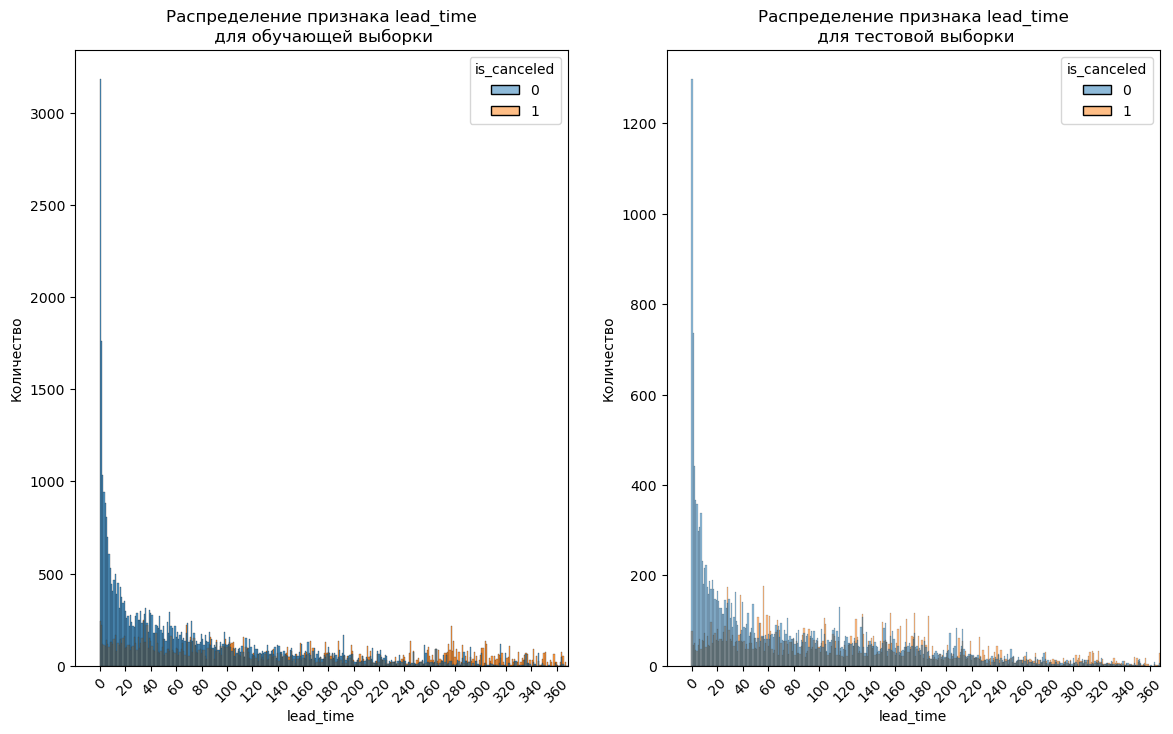

________________________________________________________________________________________________________________________
arrival_date_month


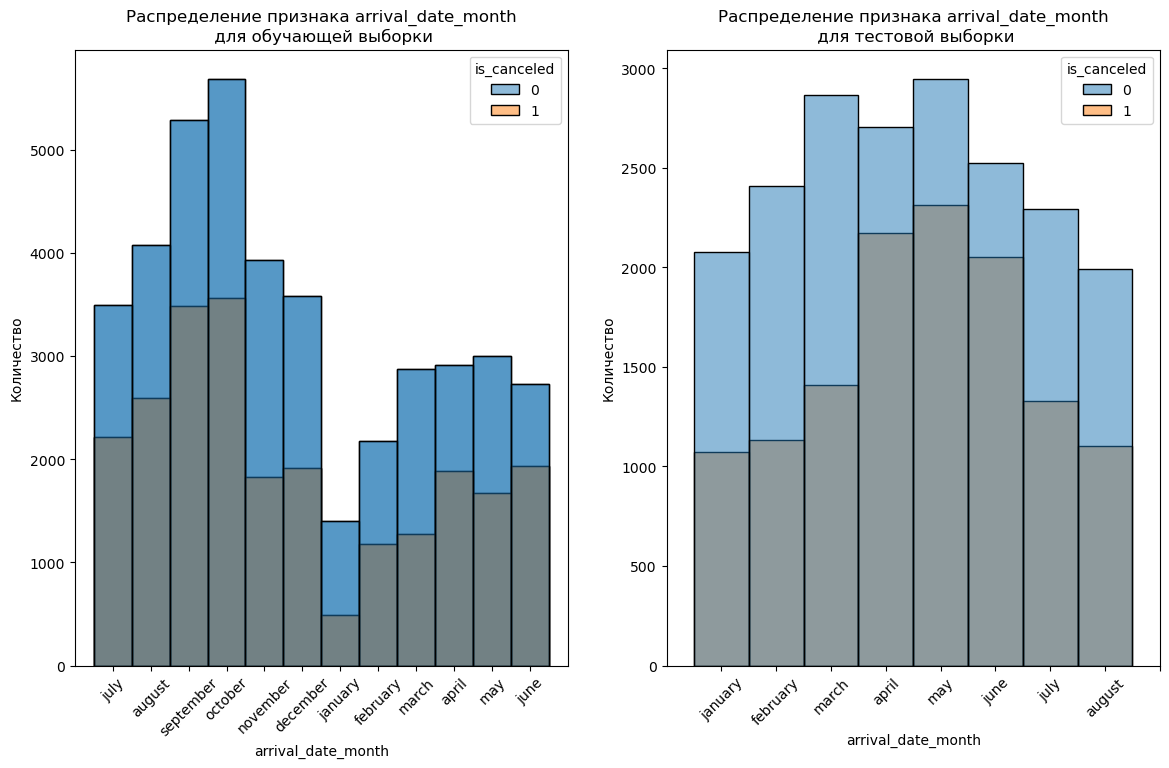

________________________________________________________________________________________________________________________
stays_in_weekend_nights


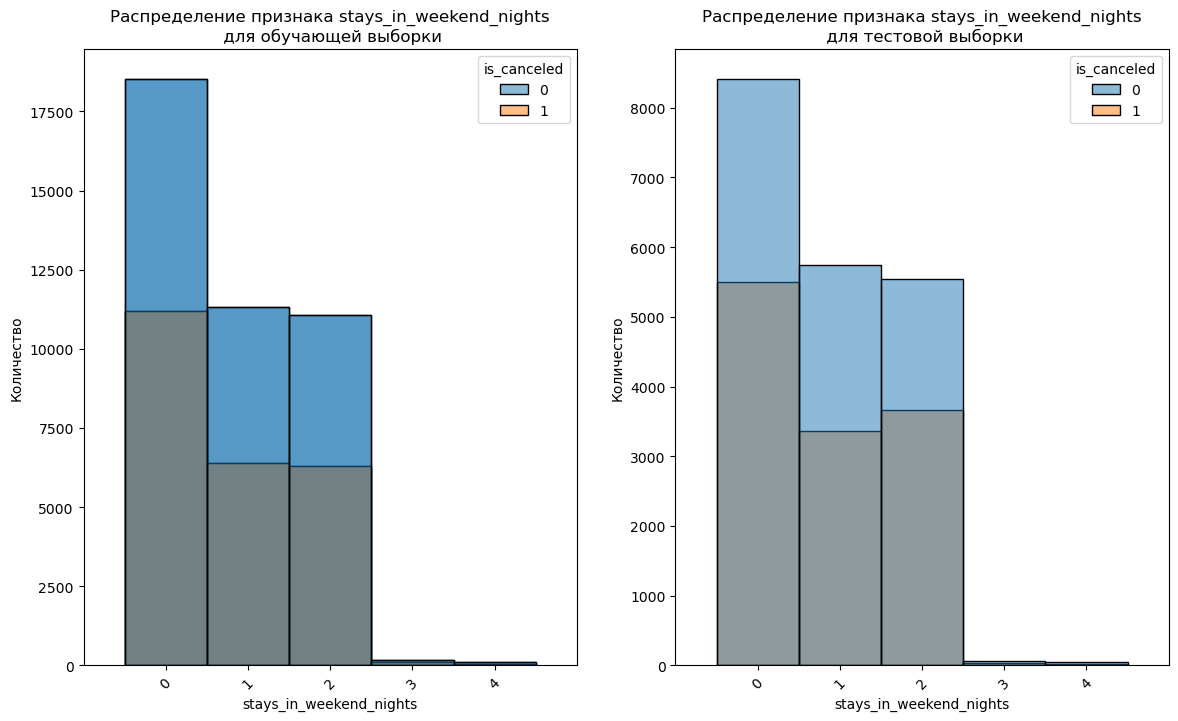

________________________________________________________________________________________________________________________
stays_in_week_nights


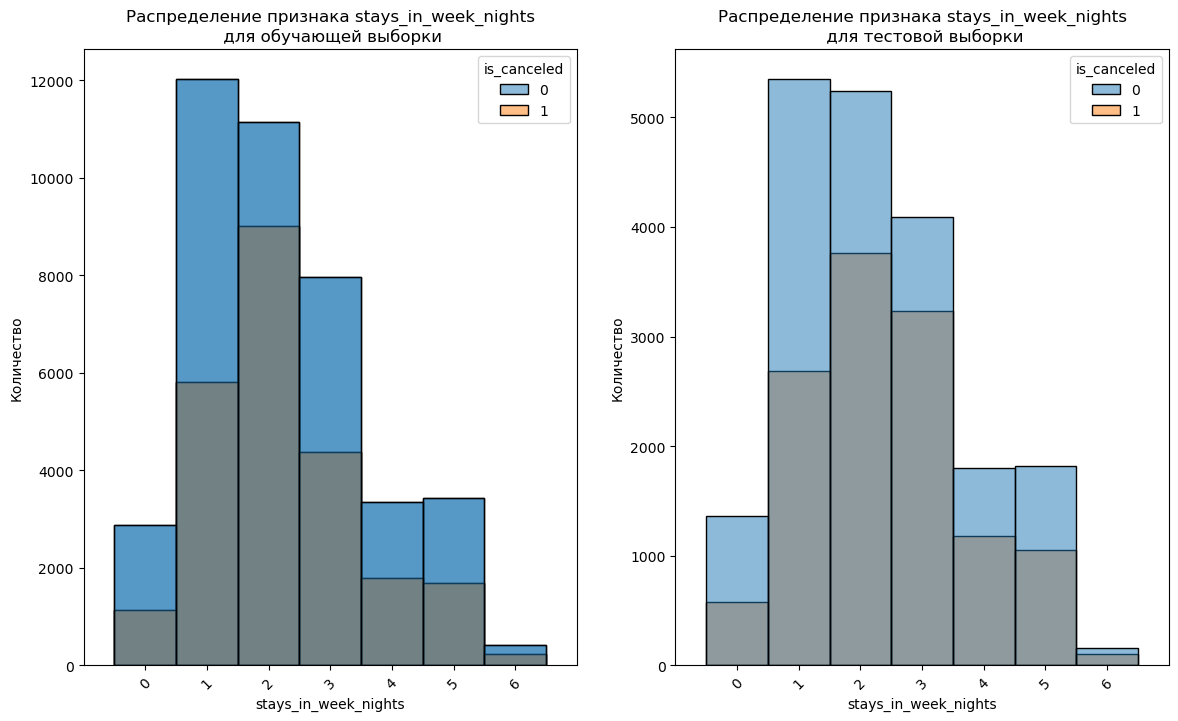

________________________________________________________________________________________________________________________
adults


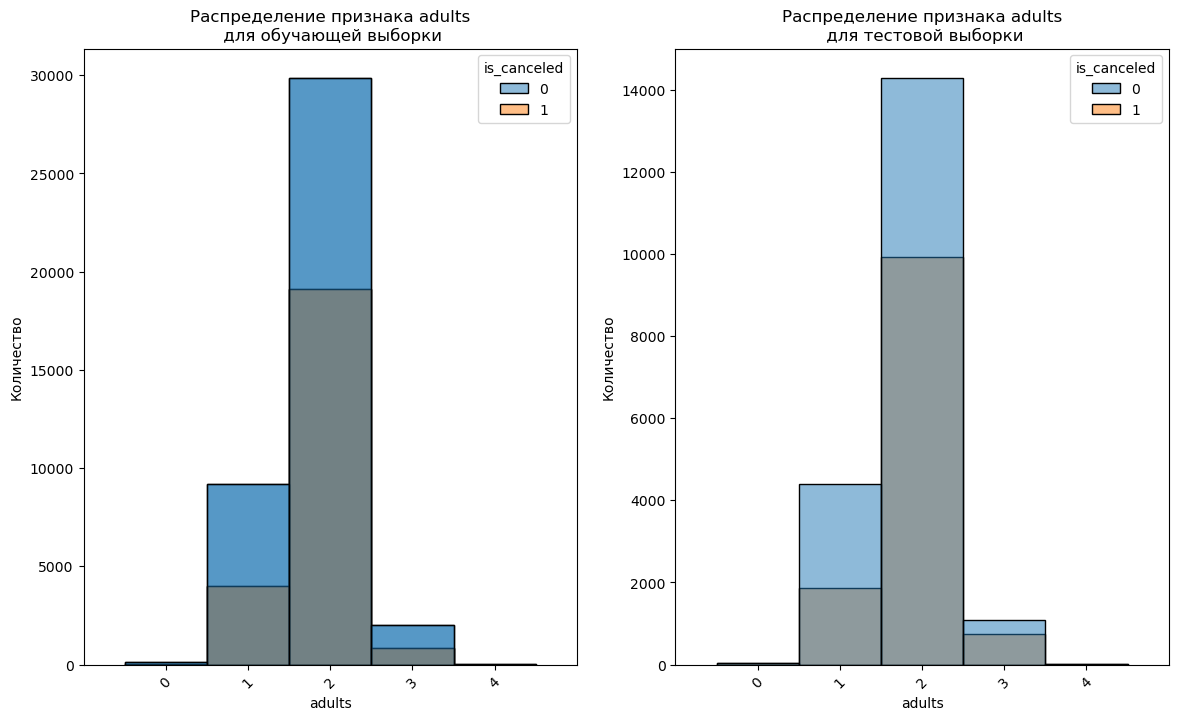

________________________________________________________________________________________________________________________
children


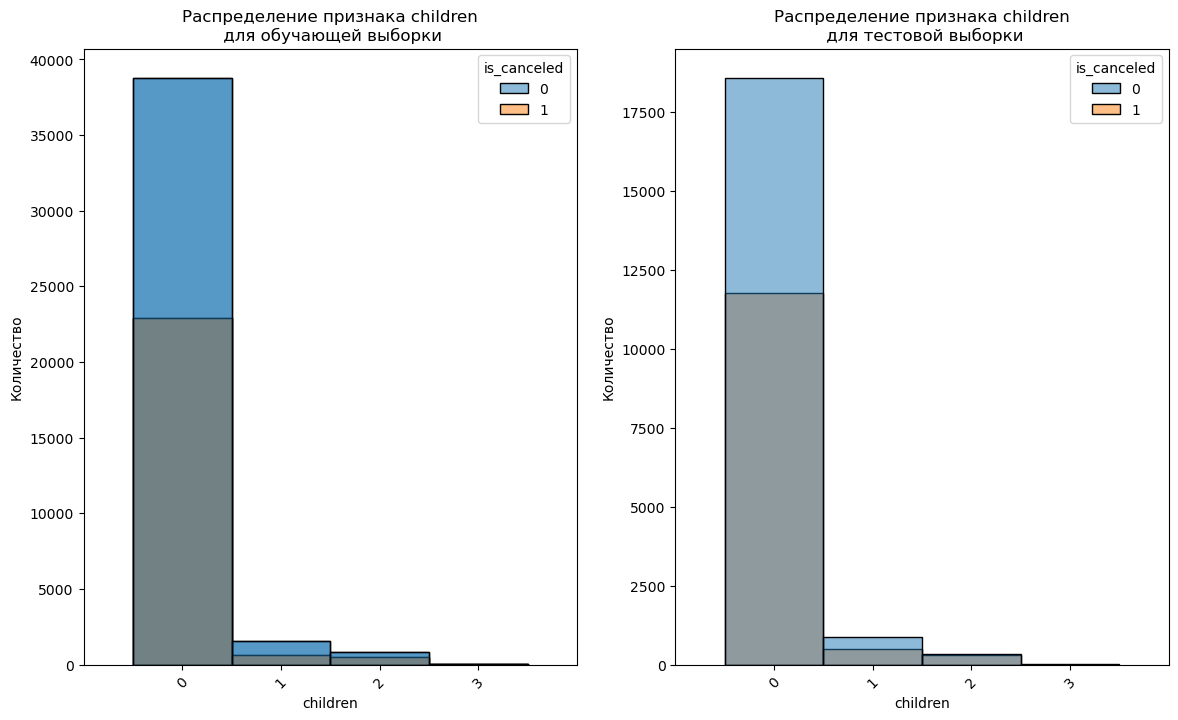

________________________________________________________________________________________________________________________
babies


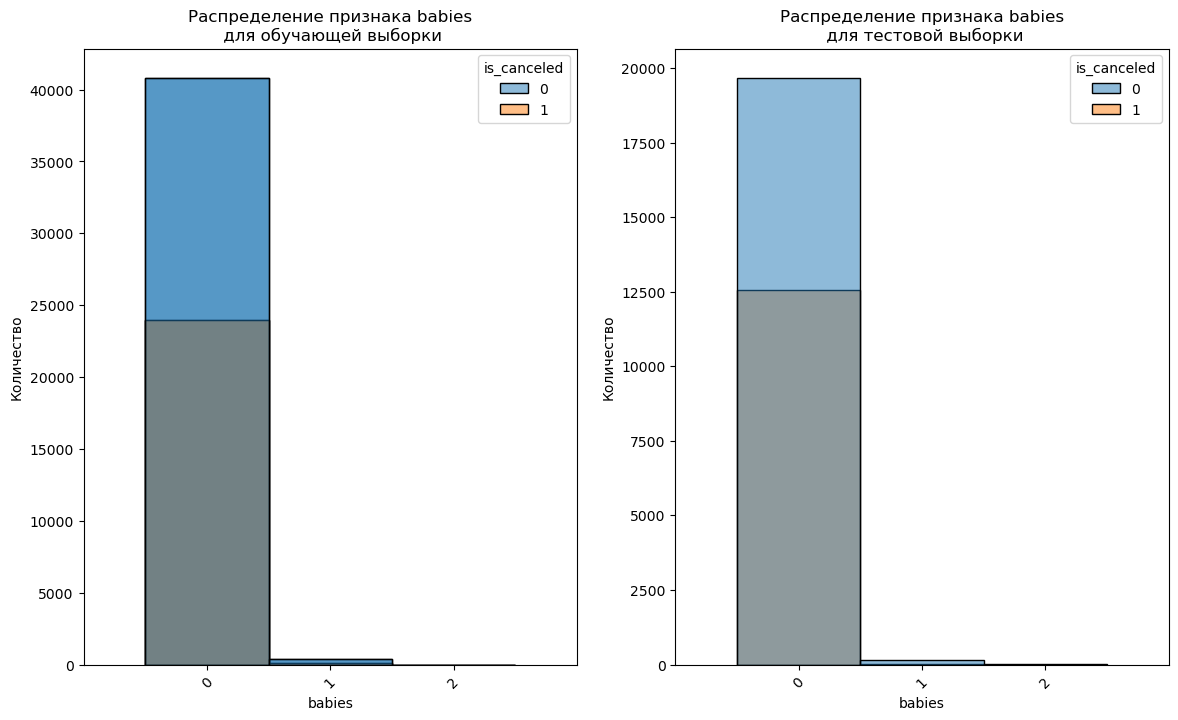

________________________________________________________________________________________________________________________
meal


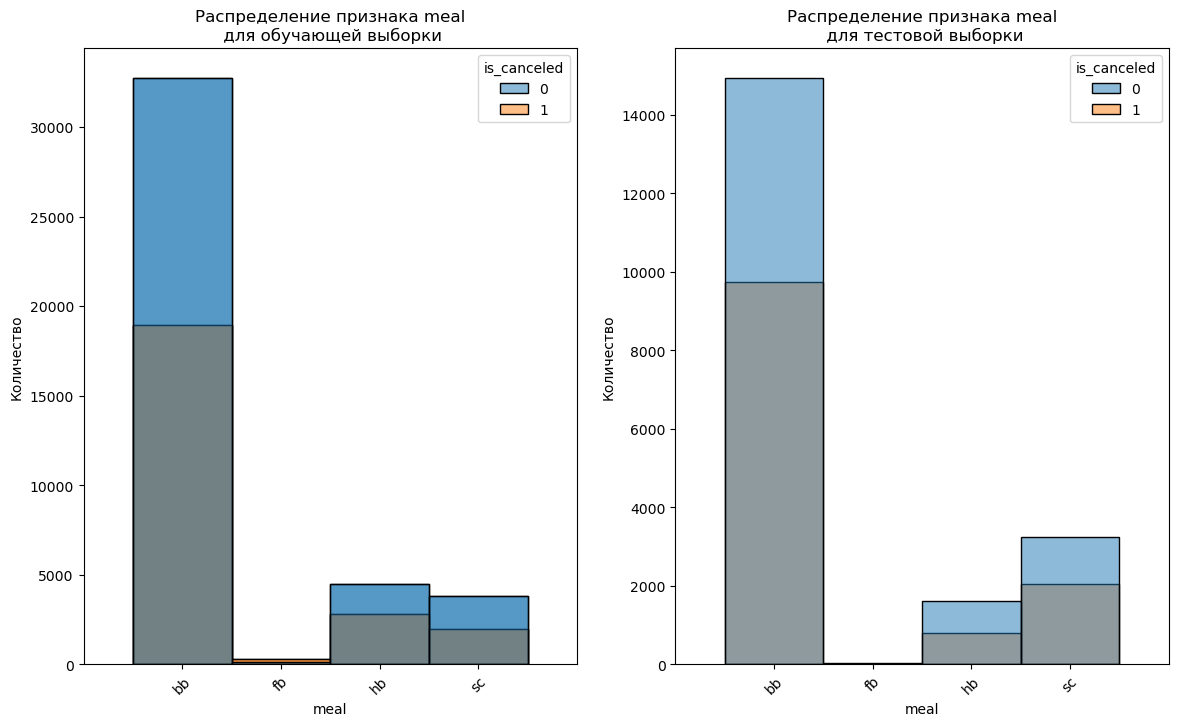

________________________________________________________________________________________________________________________
country


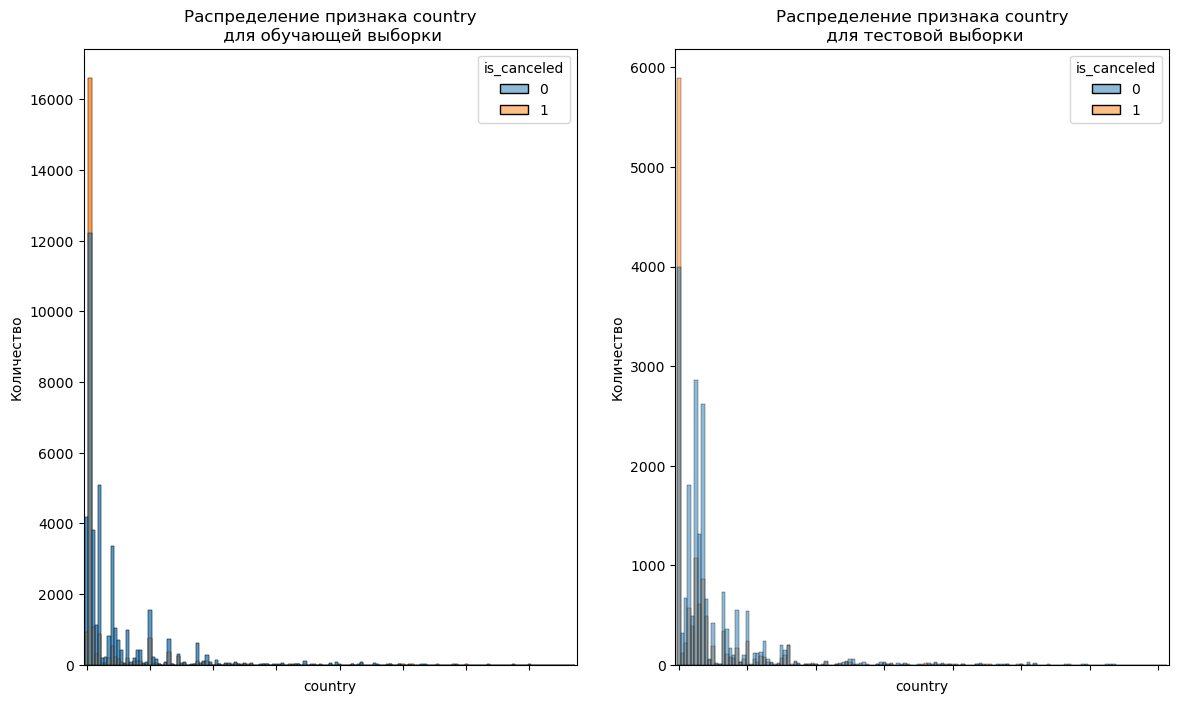

Наибольшее количество отказов в обучающей выборке - страна prt: 16604 (69.1%).
Наибольшее количество отказов в тестовой выборке - страна prt: 5893 (46.8%).
________________________________________________________________________________________________________________________
distribution_channel


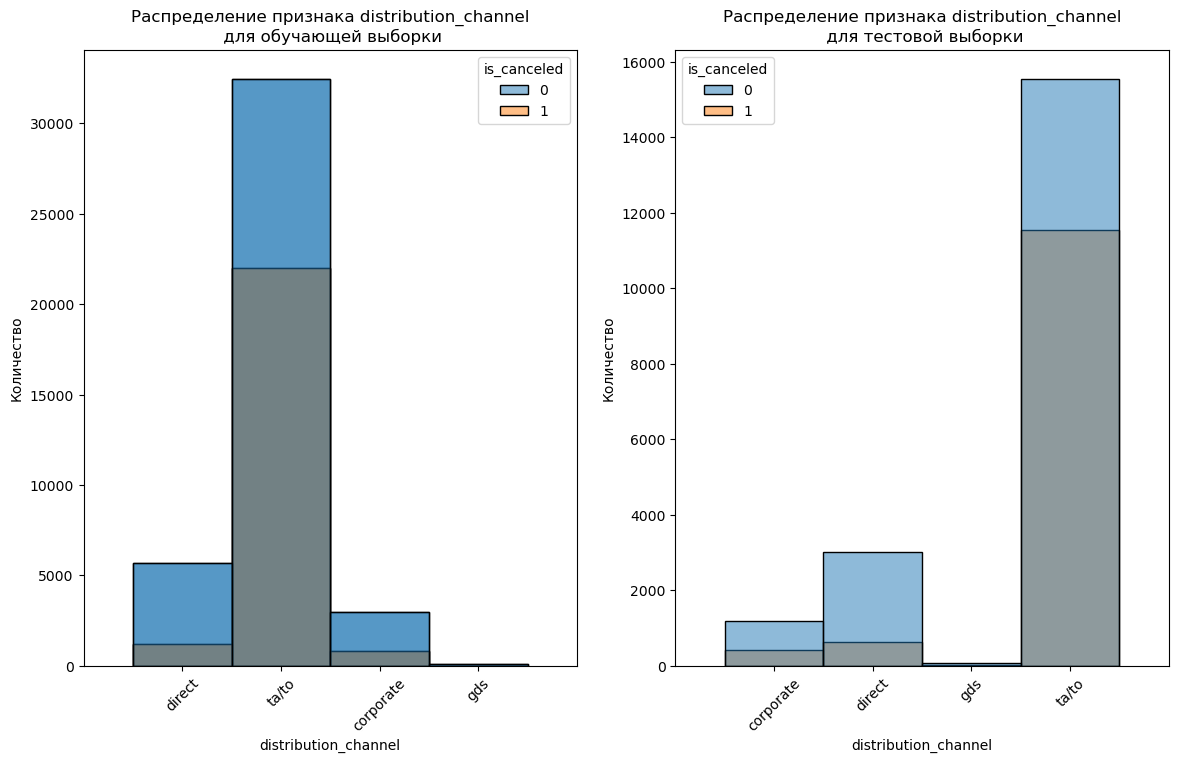

________________________________________________________________________________________________________________________
is_repeated_guest


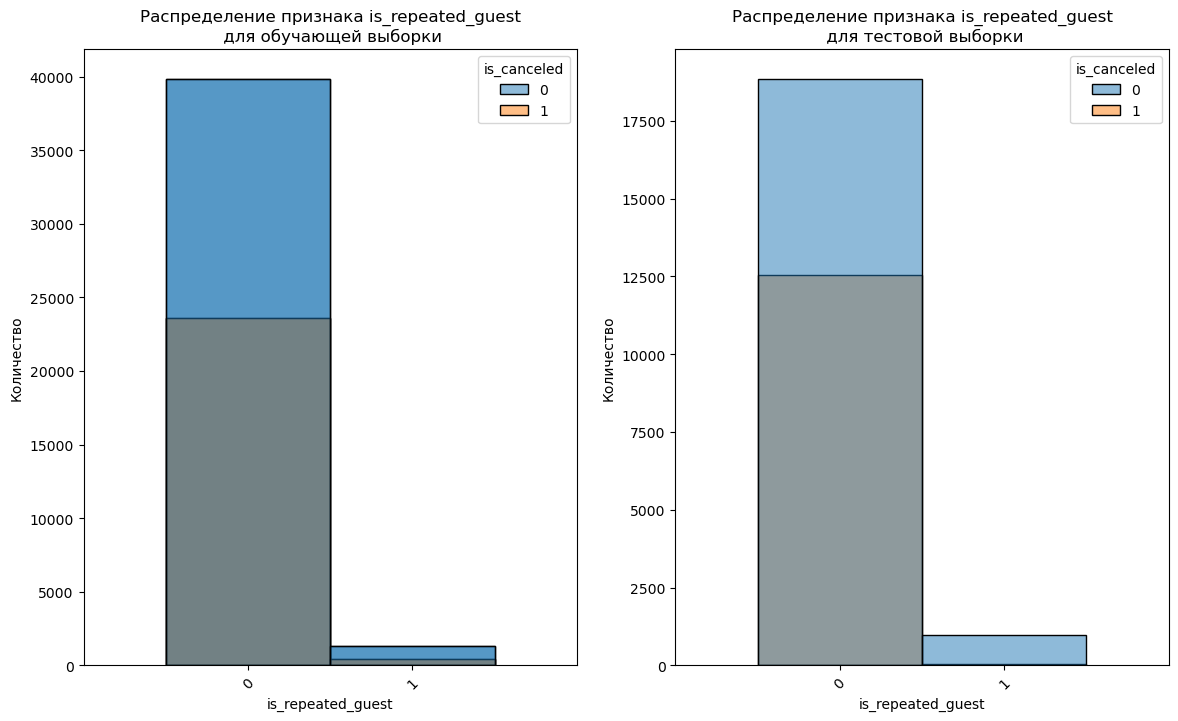

________________________________________________________________________________________________________________________
previous_cancellations


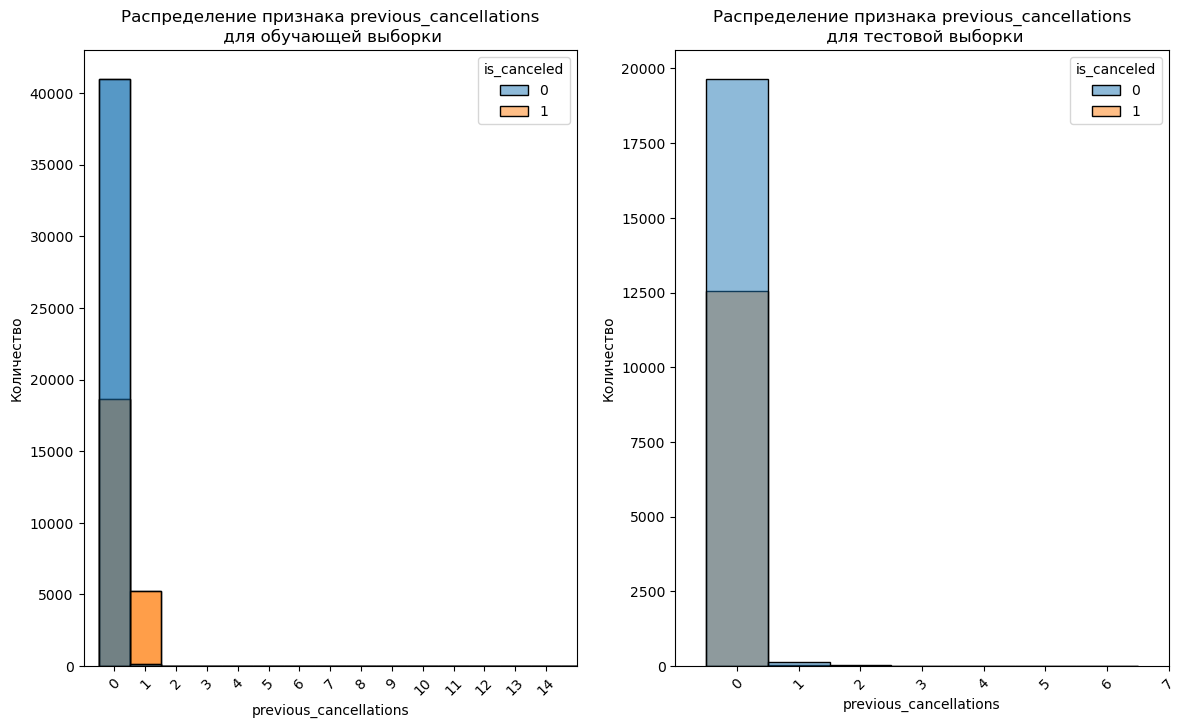

________________________________________________________________________________________________________________________
previous_bookings_not_canceled


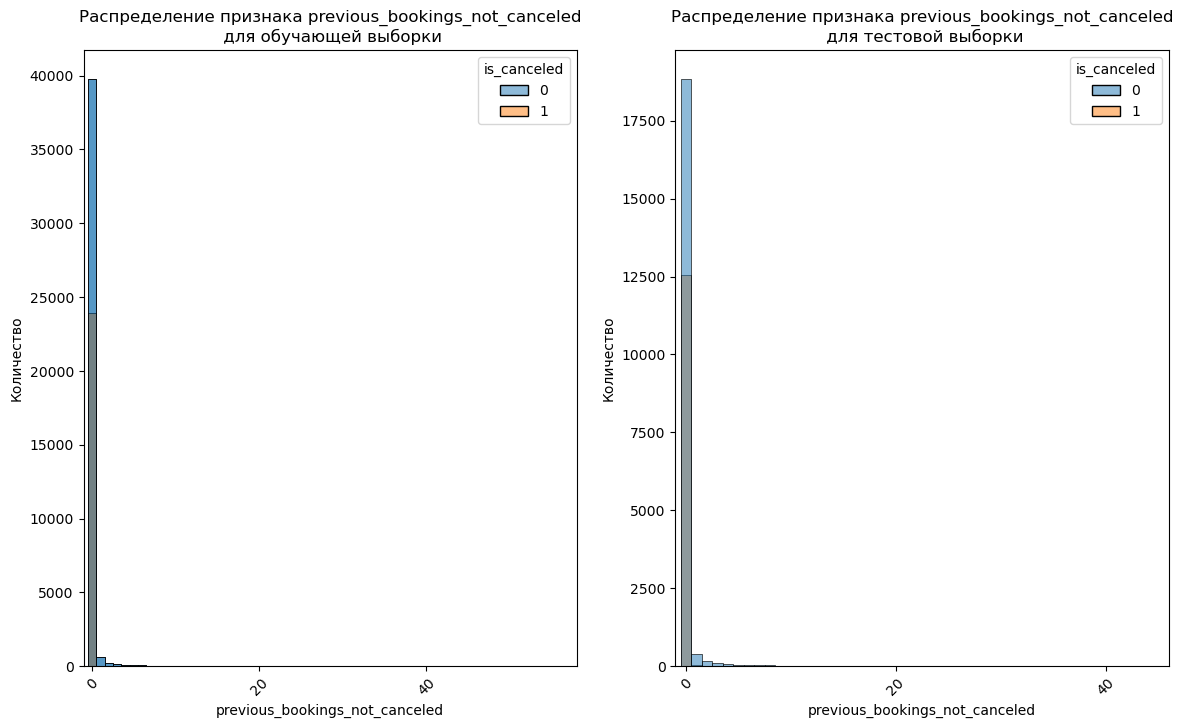

________________________________________________________________________________________________________________________
reserved_room_type


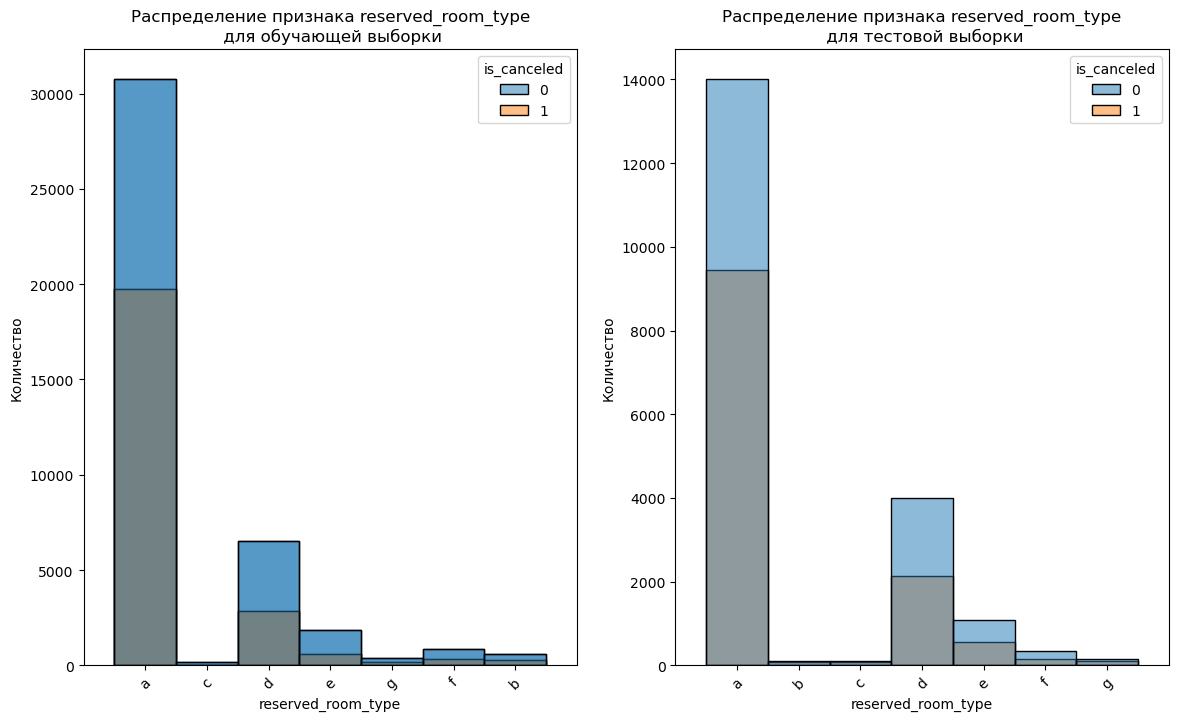

________________________________________________________________________________________________________________________
booking_changes


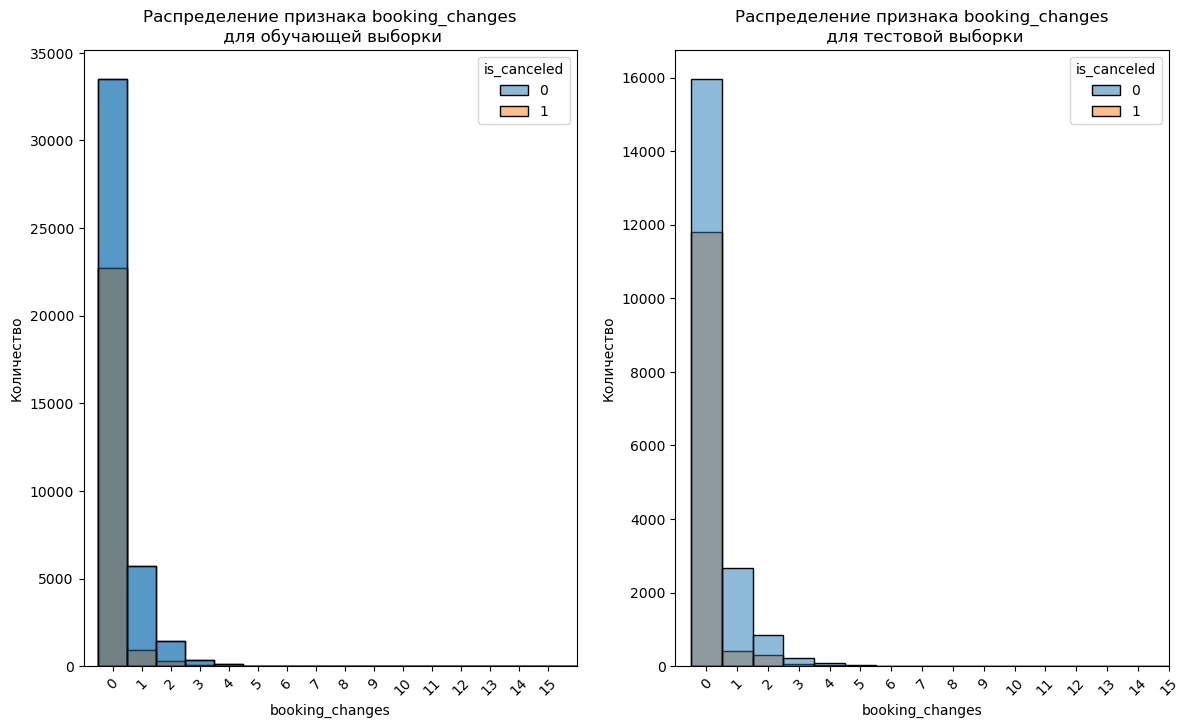

________________________________________________________________________________________________________________________
days_in_waiting_list


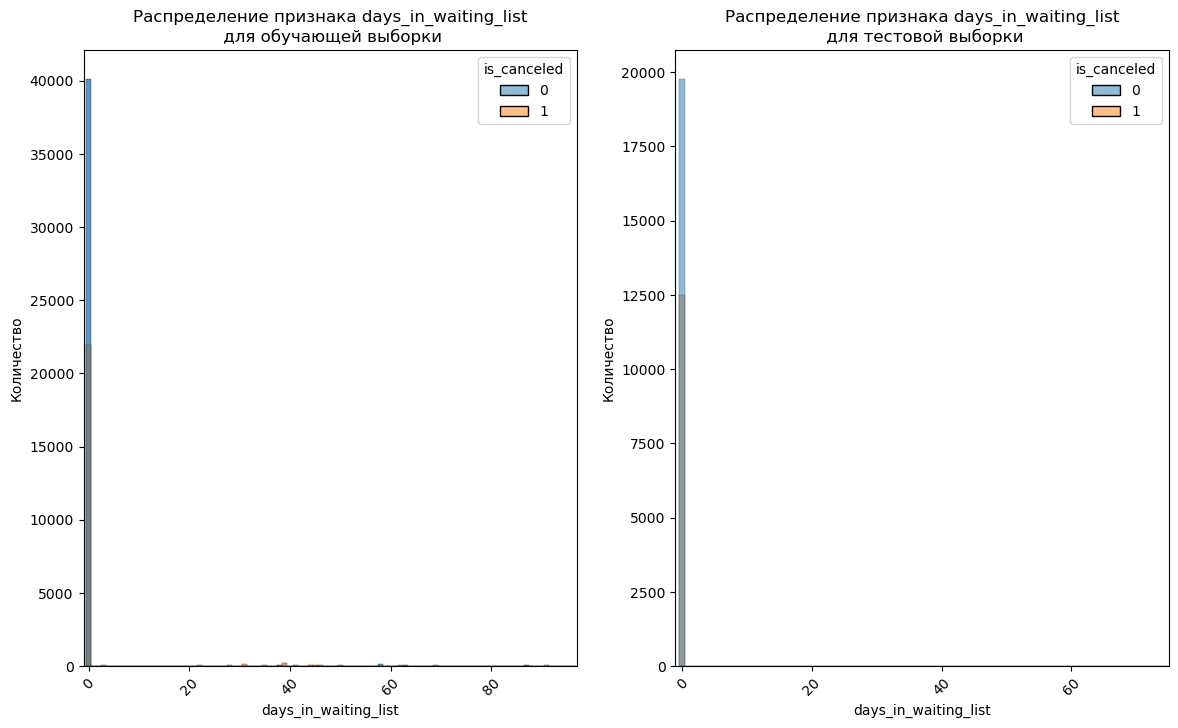

________________________________________________________________________________________________________________________
customer_type


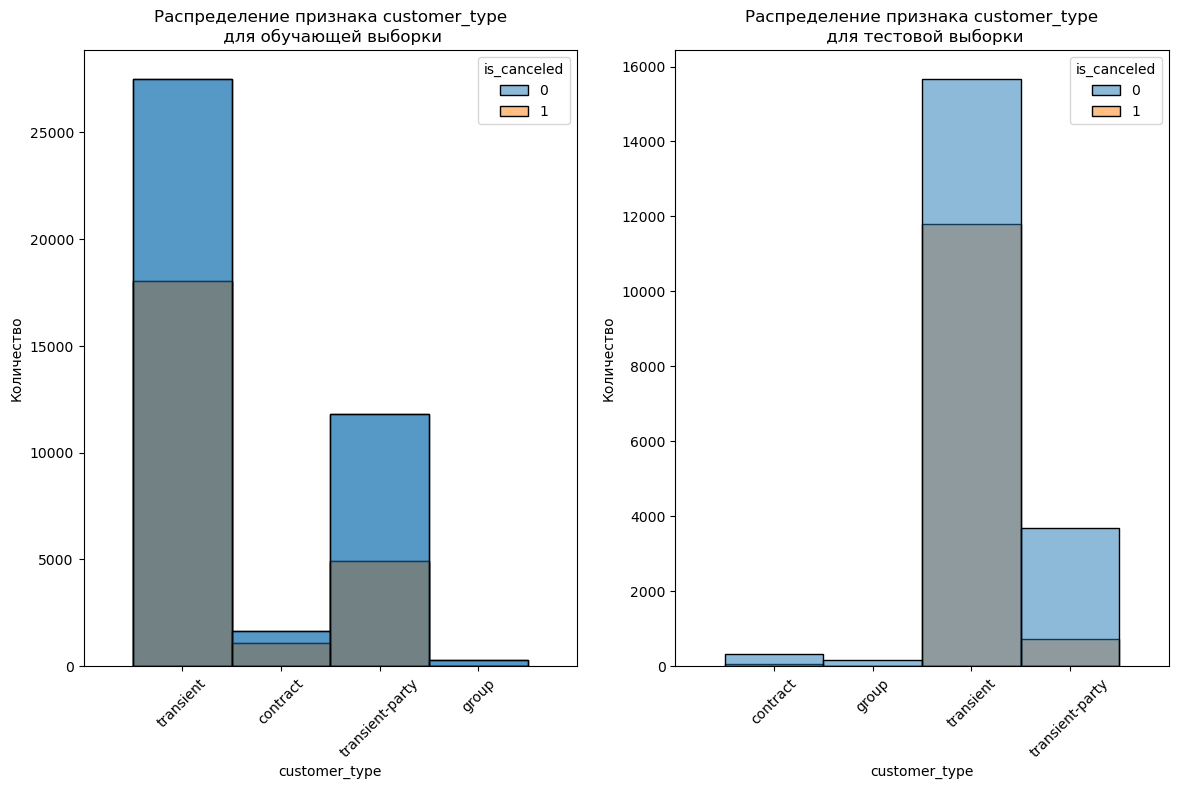

________________________________________________________________________________________________________________________
required_car_parking_spaces


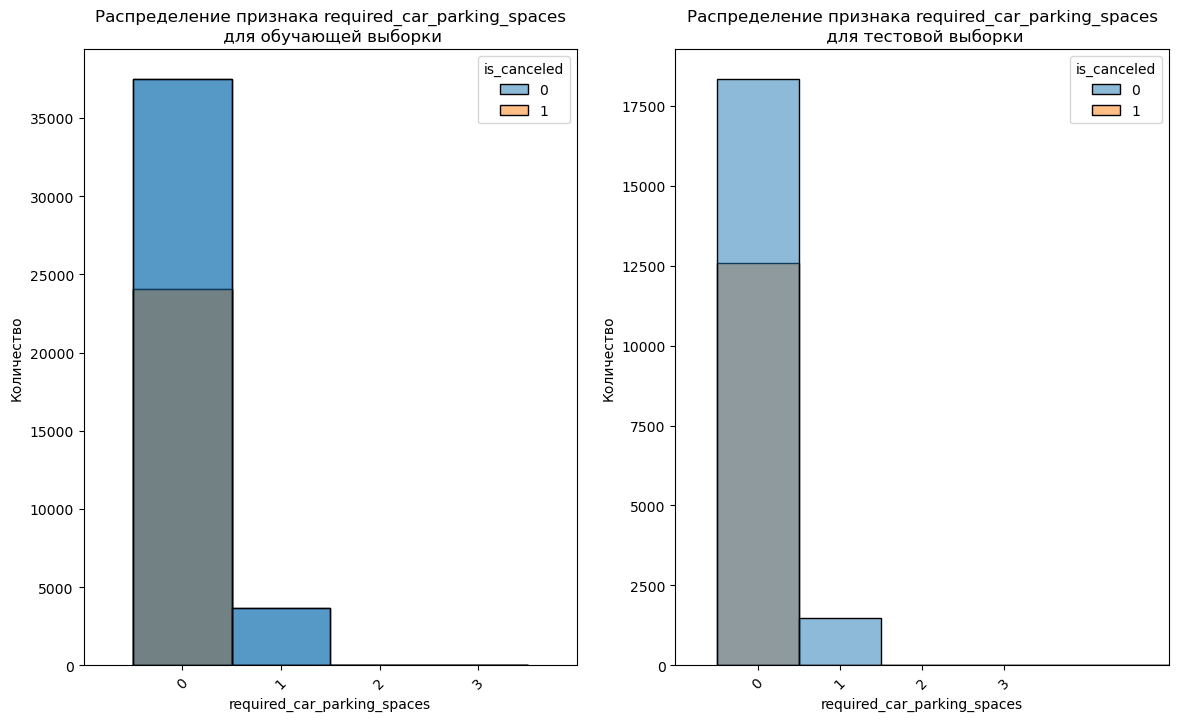

________________________________________________________________________________________________________________________
total_of_special_requests


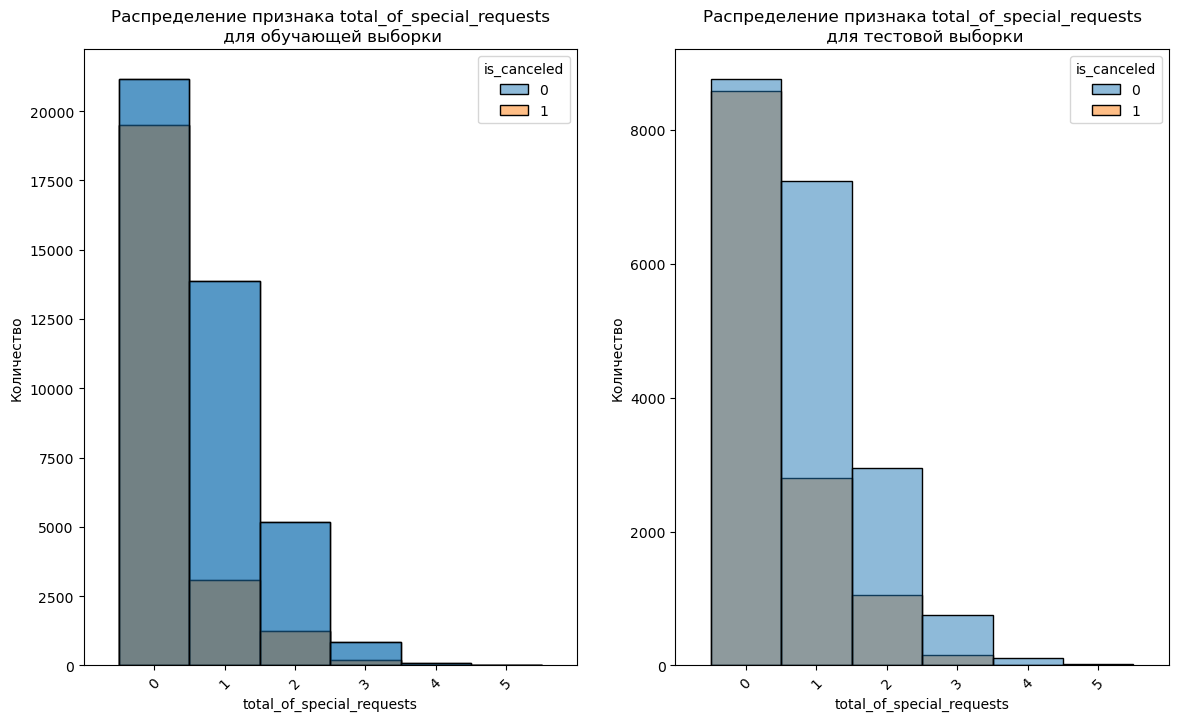

________________________________________________________________________________________________________________________
total_nights


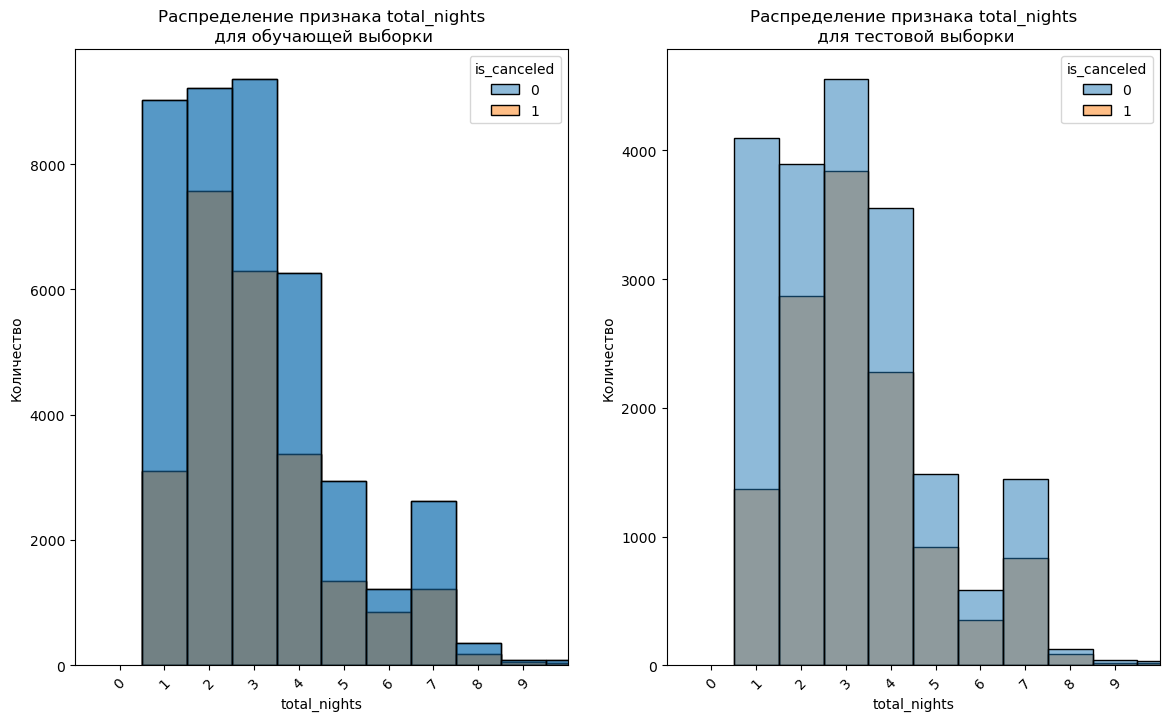

________________________________________________________________________________________________________________________


In [15]:
histogr(df_train, df_test)

1. Клиенты, не отменившие бронь, значительно чаще бронируют номера менее чем за месяц до заселения.  
Клиенты, отменившие бронь, в равной степени бронируют номера на срок от 0 до 365 дней до заселения.  
2. Во второй половине года (июль-декабрь) номера бронируются чаще, нежели в первой (январь-июнь). Пик количества бронирований приходится на сентябрь-октябрь, минимум - на январь.  
3. Наиболее часто номера бронируются на будние дни. Наиболее часто - на 1-3 будних дня.  
Клиенты, не отменившие бронь, чаще бронируют номер на один будний день.
Клиенты, отменившие бронь, чаще бронируют номер на два будних дня.  
4. Клиенты, как отменившие бронь, так и не отменившие, чаще бронируют номера на двух взрослых без детей и младенцев.  
5. Клиенты, как отменившие бронь, так и не отменившие, чаще оформляют бронь с включенным в заказ завтраком, реже всего - с завтраком, обедом и ужином.  
6. Наибольшее число клиентов - португальцы. При этом количество "отказников" среди них превышает количество надежных клиентов.  
7. Наиболее популярный канал дистрибуции заказа - "ta/to", наименее - "gds".
8. У большинства клиентов нет отменённых заказов и признаков повторного бронирования номера. За 2015-2016 годы около 5000 тысяч клиентов, отменивших бронь, ранее имели отмененные заказы.   
9. Наиболее часто бронируются самые дорогие номера - тип А.  
10. Заказы, как правило, подтверждаются в день оформления.  
11. Большинство заказов не связано с договором или групповым заездом.  

[Вернуться к содержанию](#start) 

**Диаграммы размаха**

Строим диаграммы размаха:

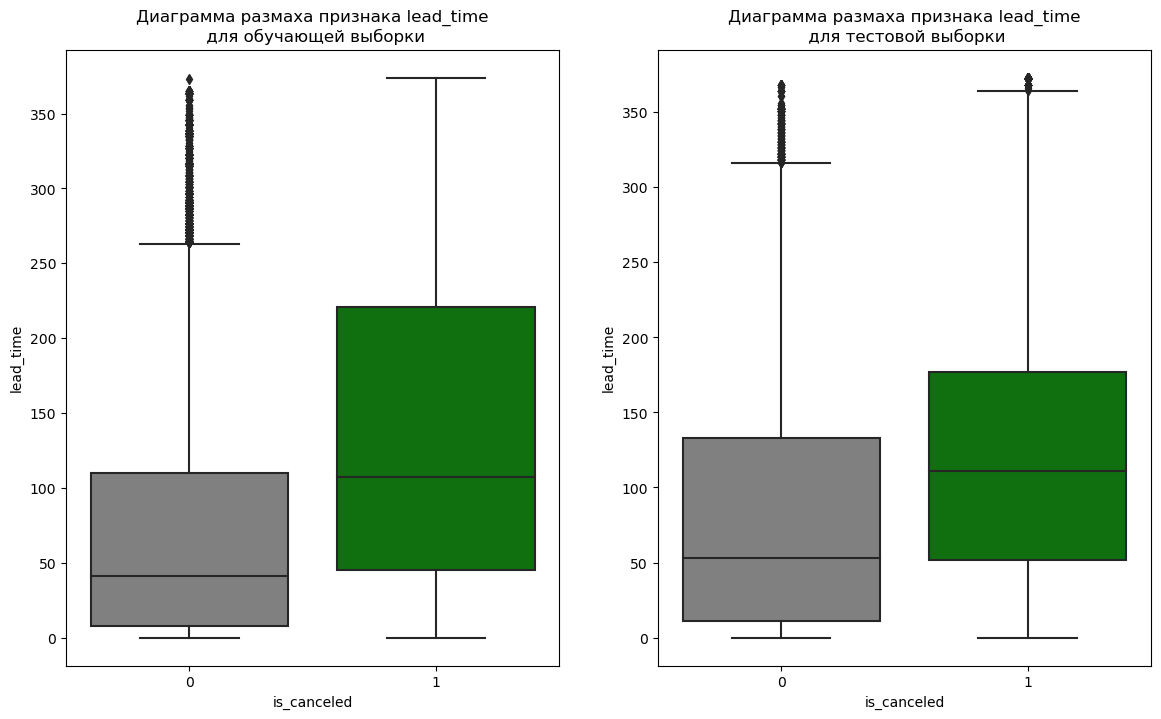

________________________________________________________________________________________________________________________


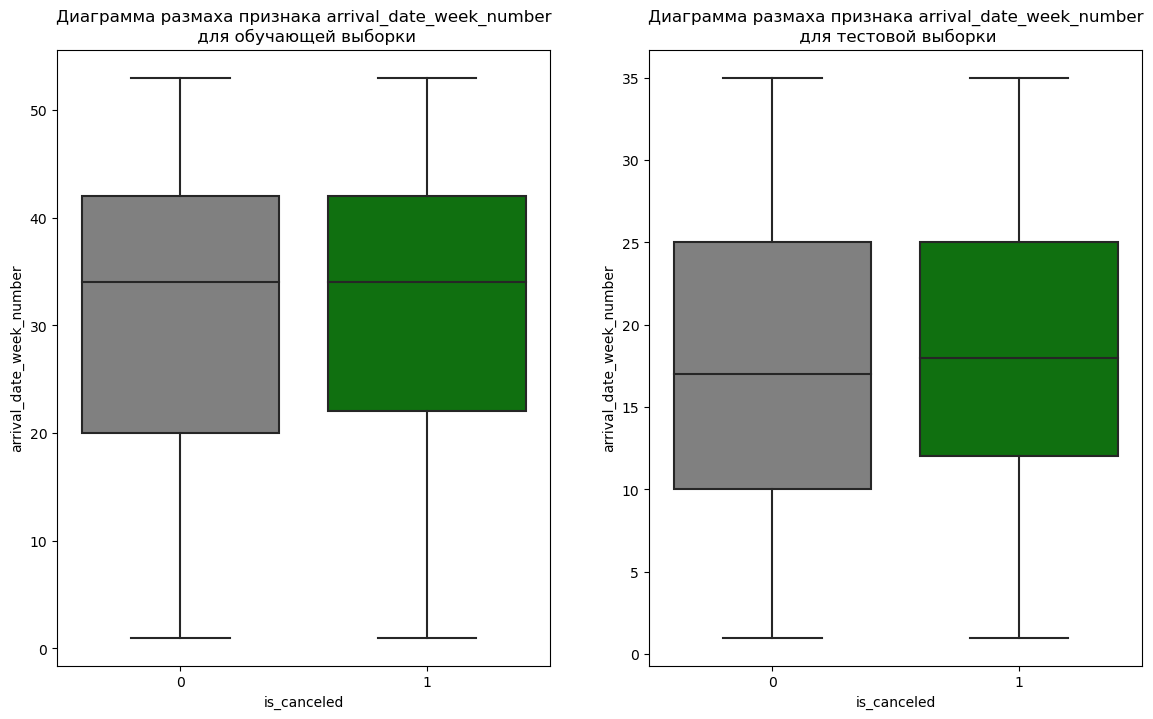

________________________________________________________________________________________________________________________


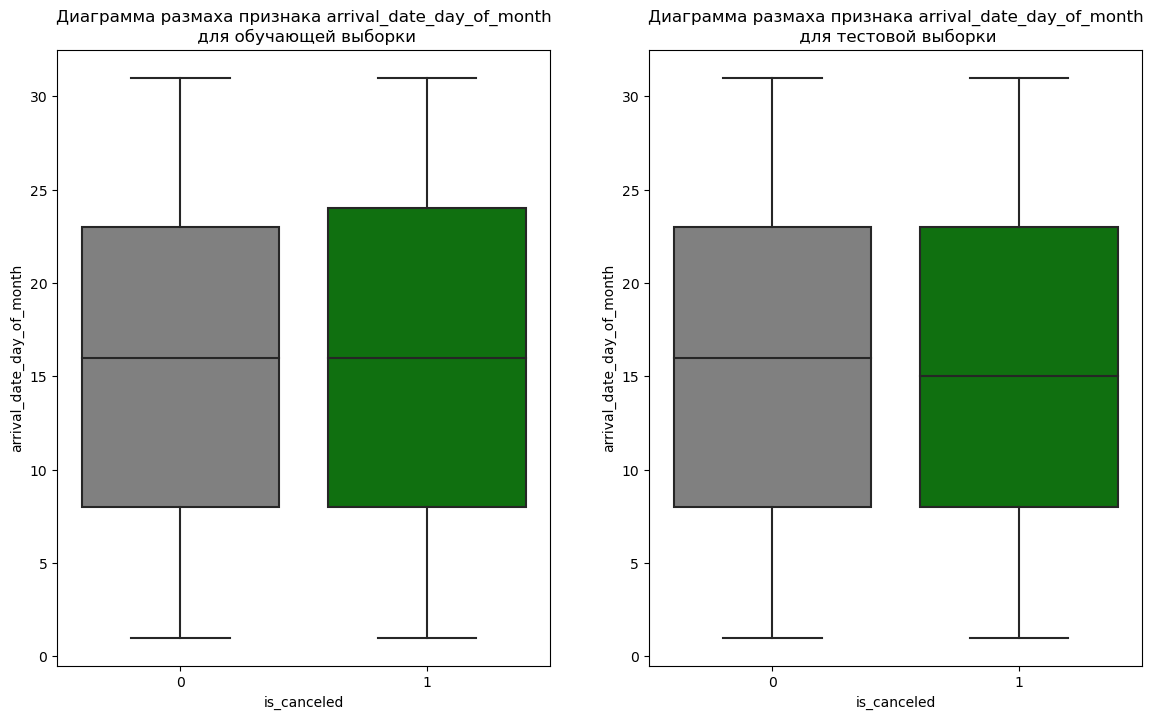

________________________________________________________________________________________________________________________


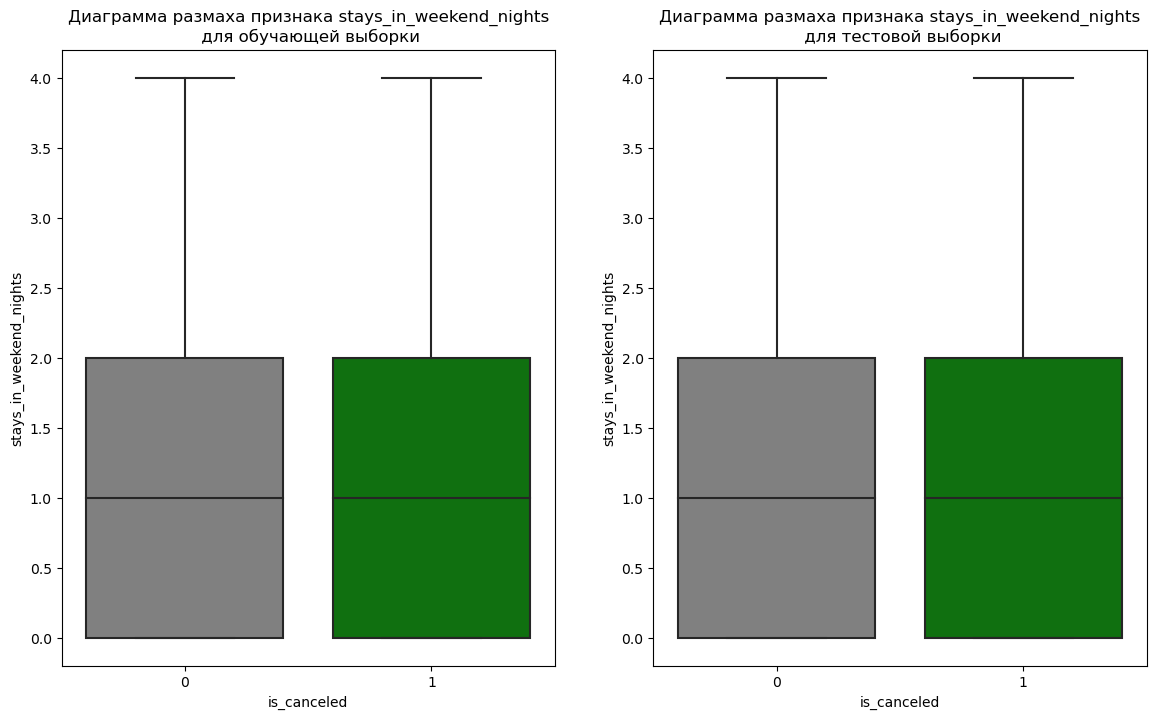

________________________________________________________________________________________________________________________


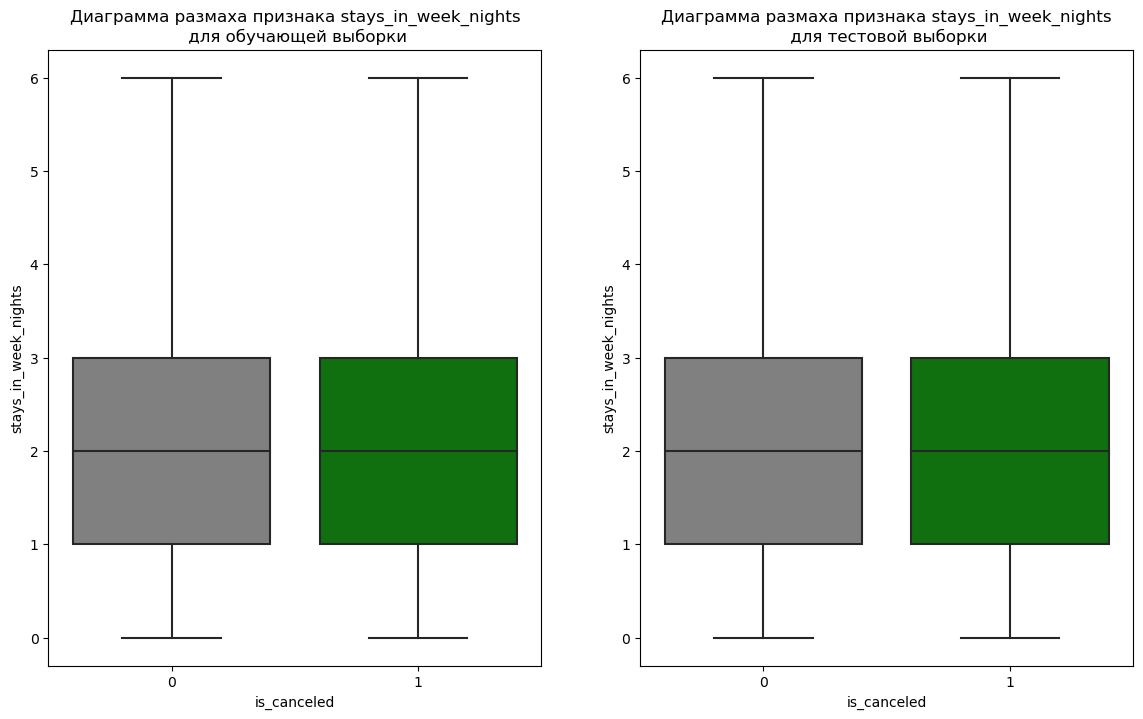

________________________________________________________________________________________________________________________


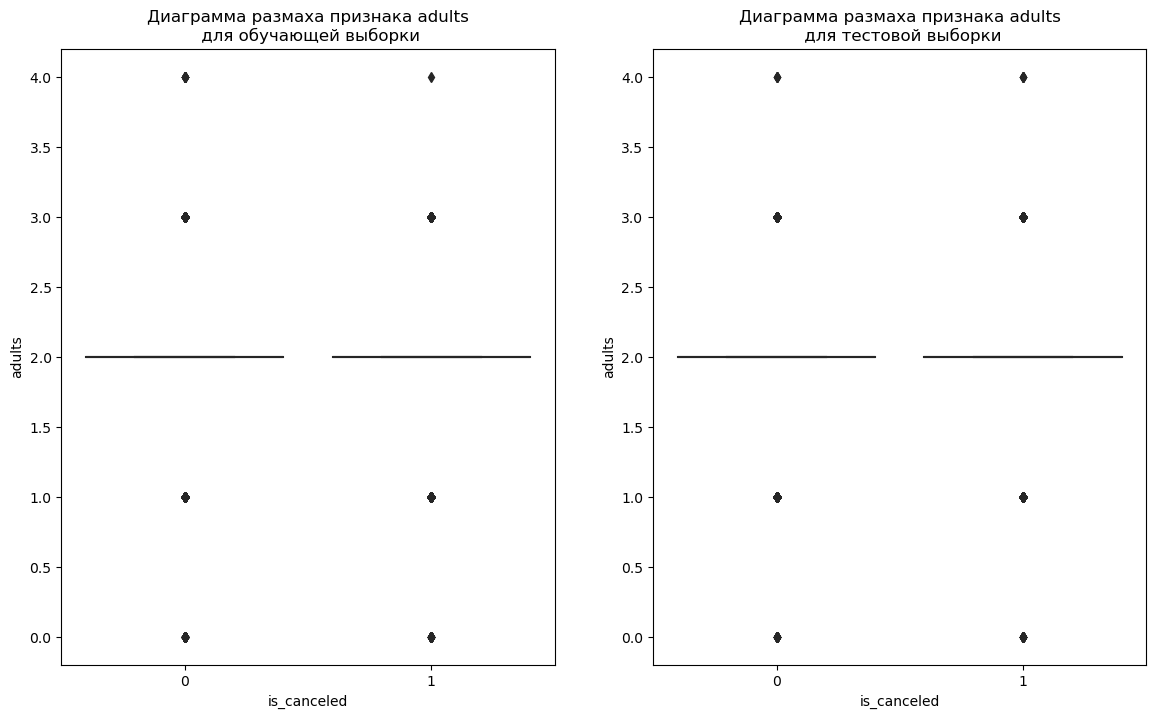

________________________________________________________________________________________________________________________


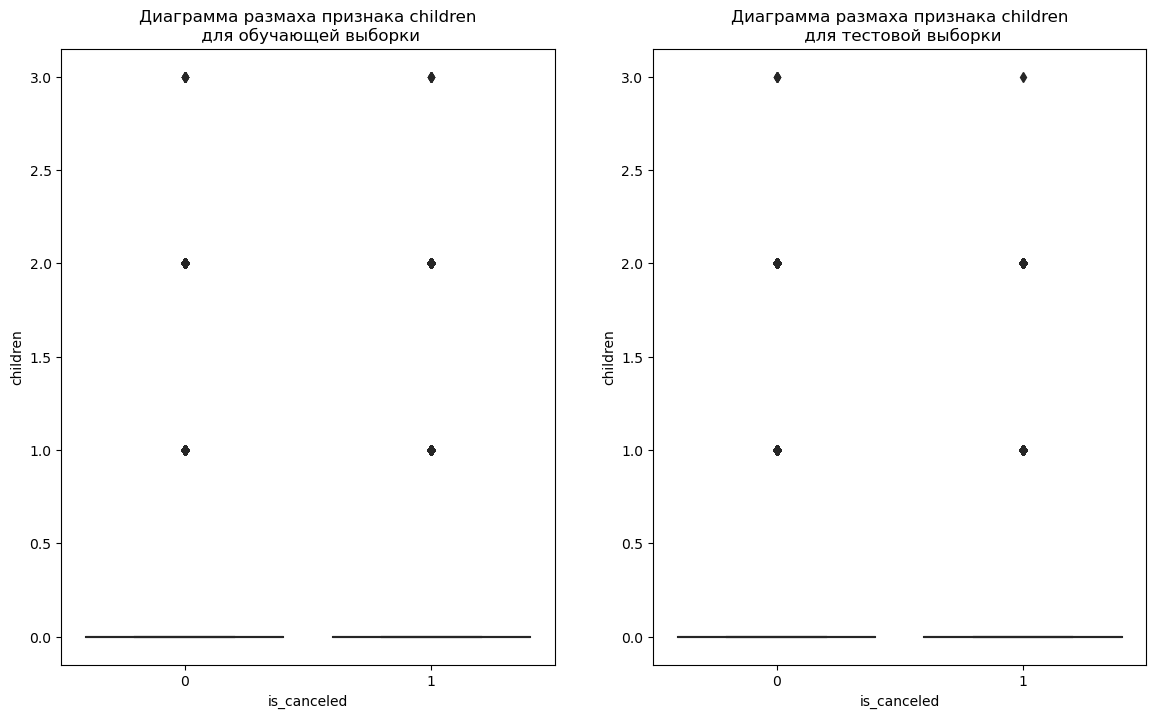

________________________________________________________________________________________________________________________


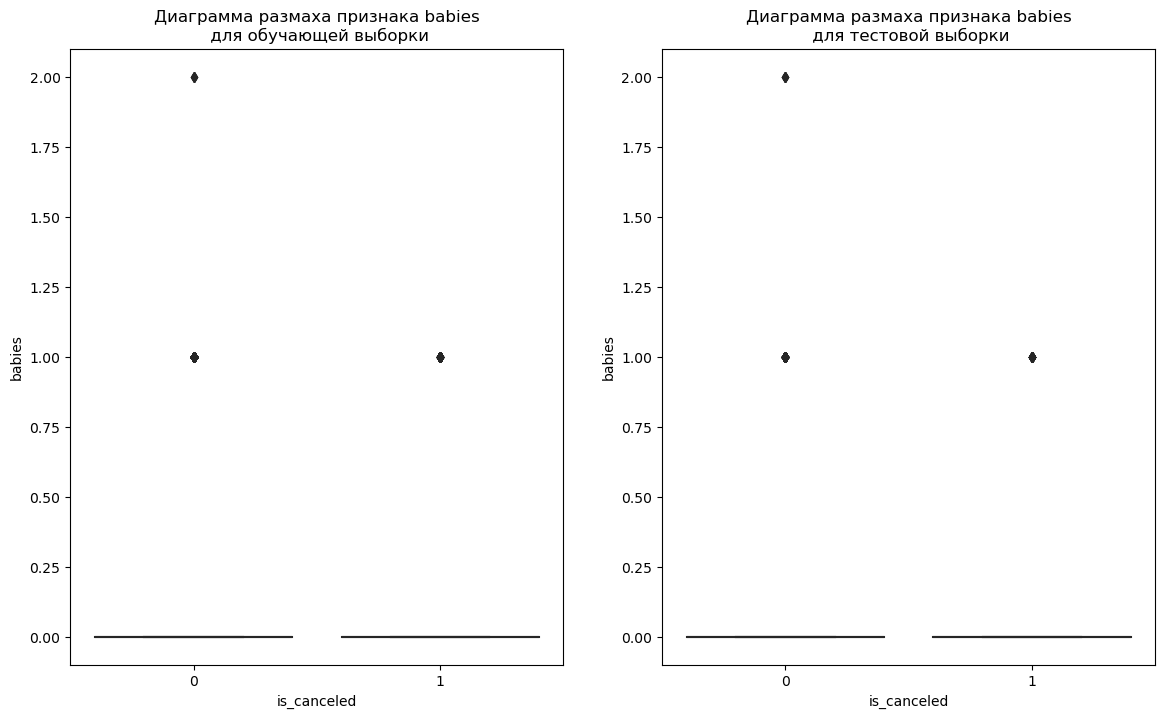

________________________________________________________________________________________________________________________


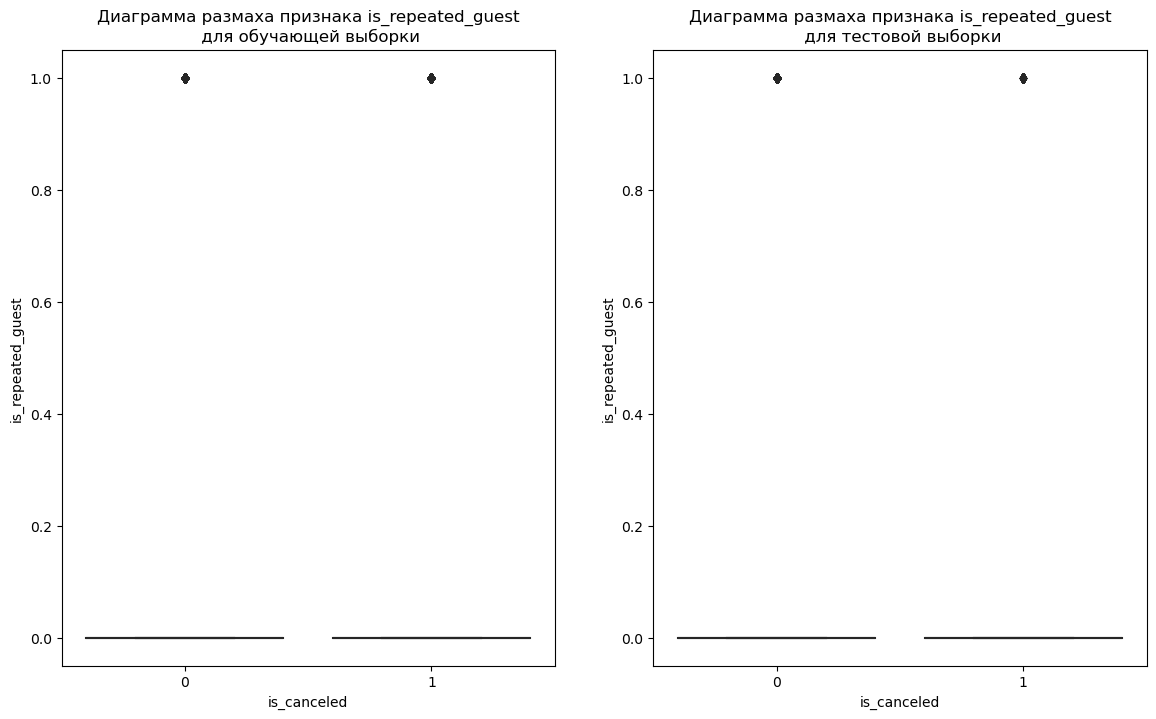

________________________________________________________________________________________________________________________


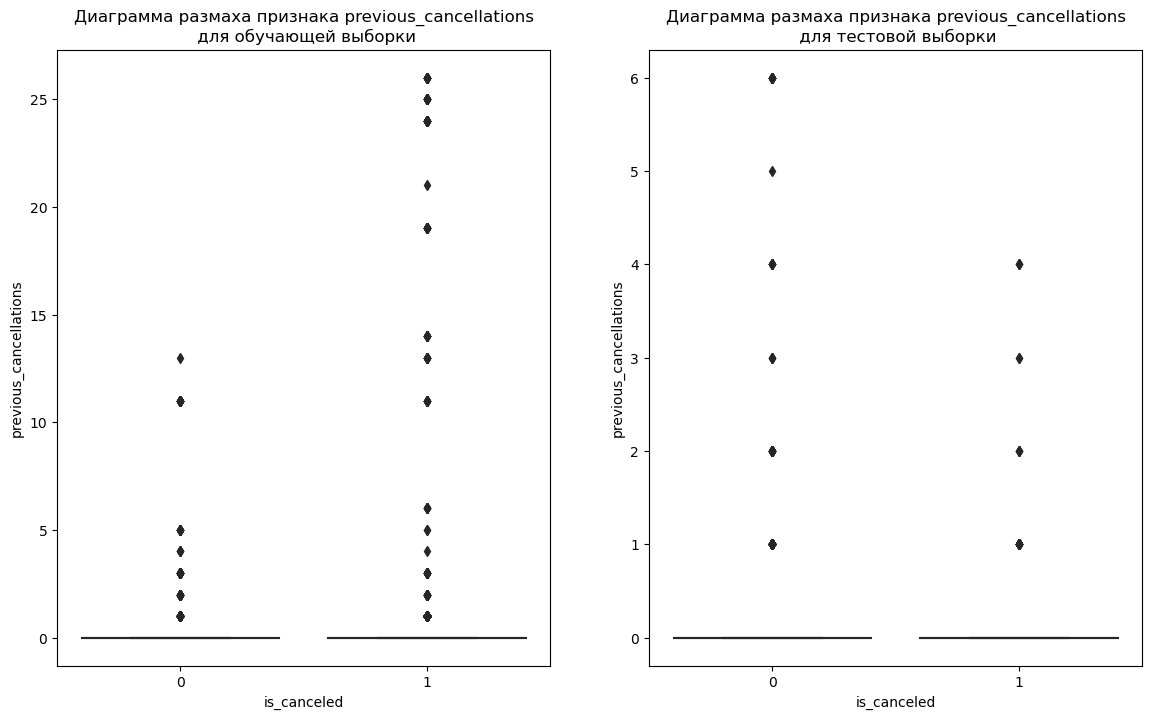

________________________________________________________________________________________________________________________


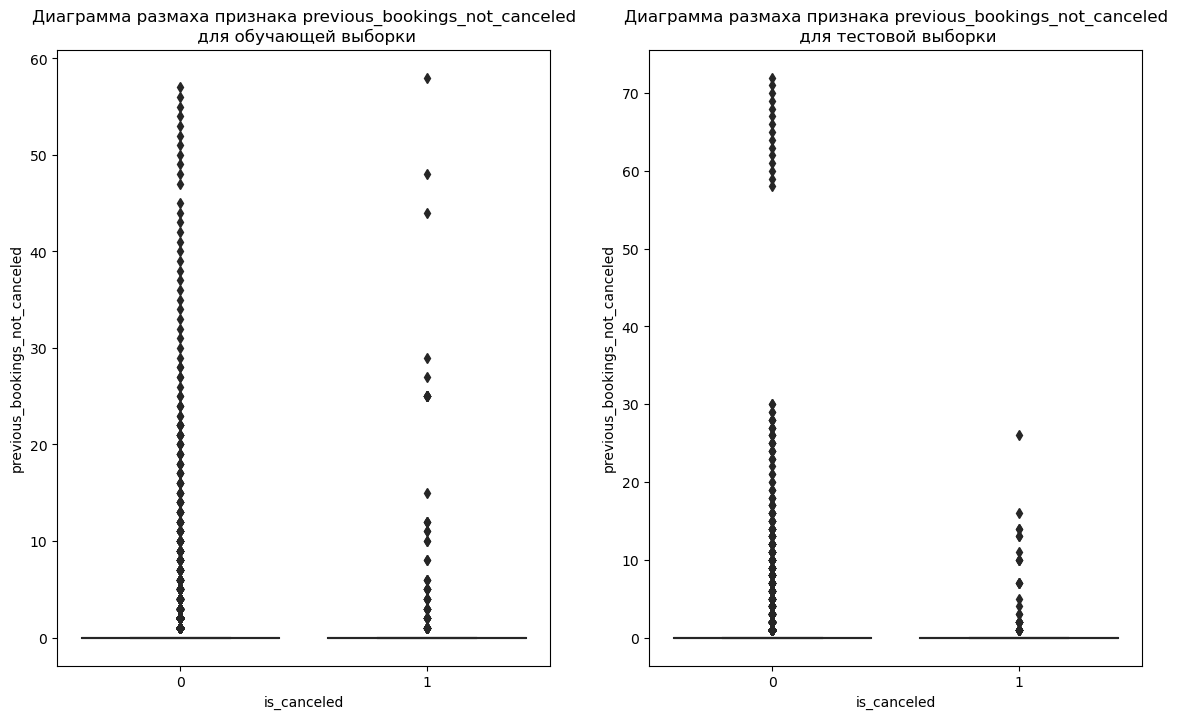

________________________________________________________________________________________________________________________


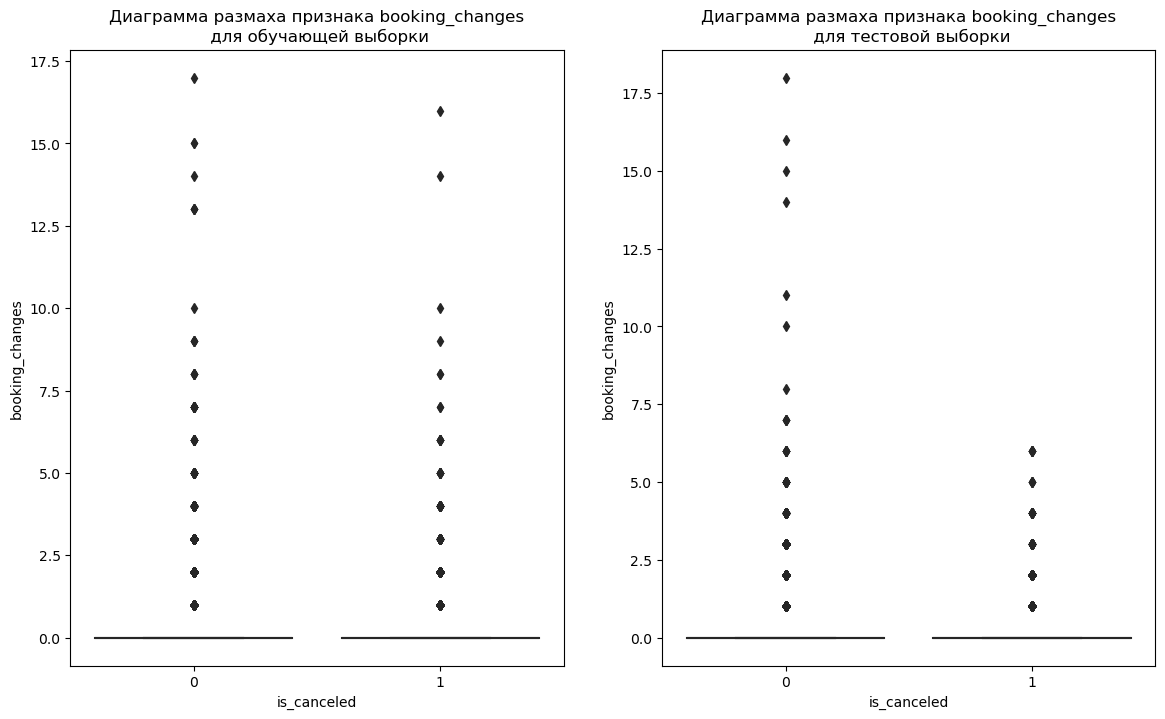

________________________________________________________________________________________________________________________


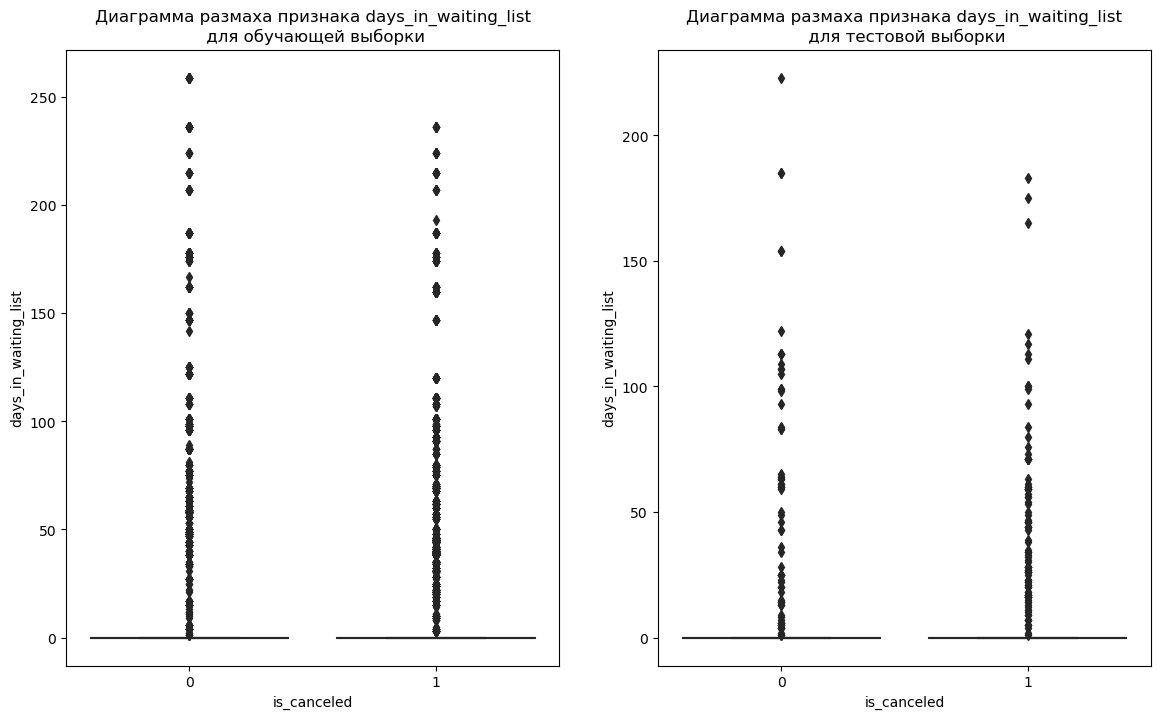

________________________________________________________________________________________________________________________


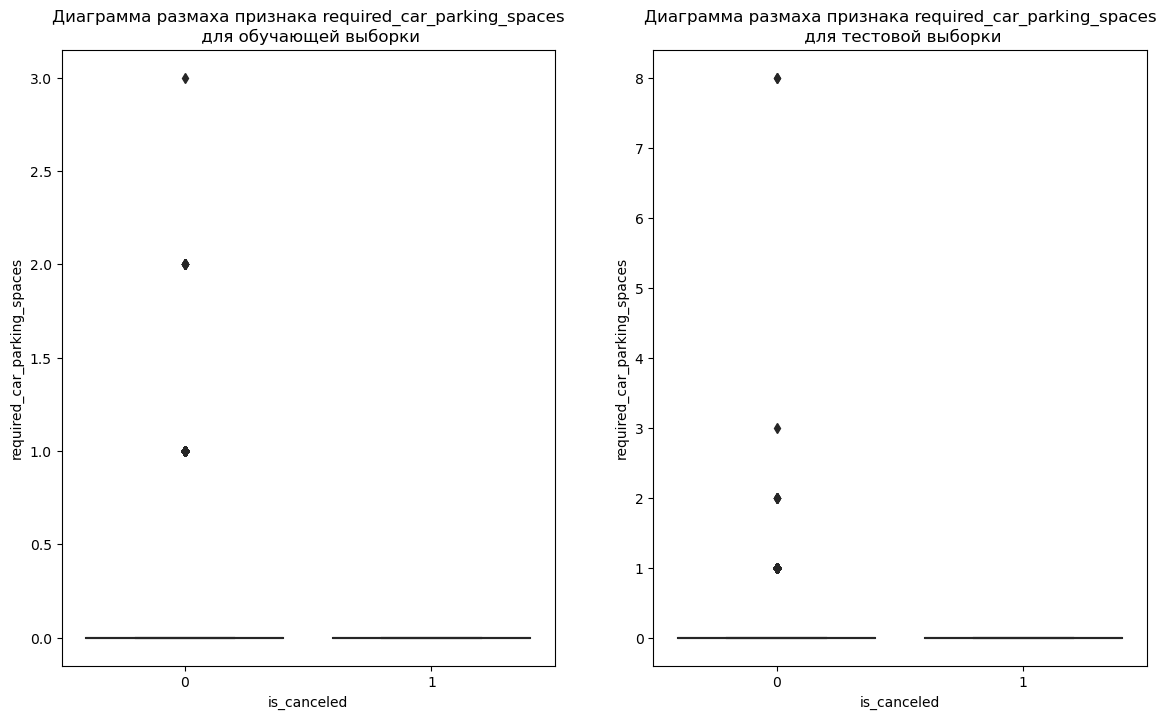

________________________________________________________________________________________________________________________


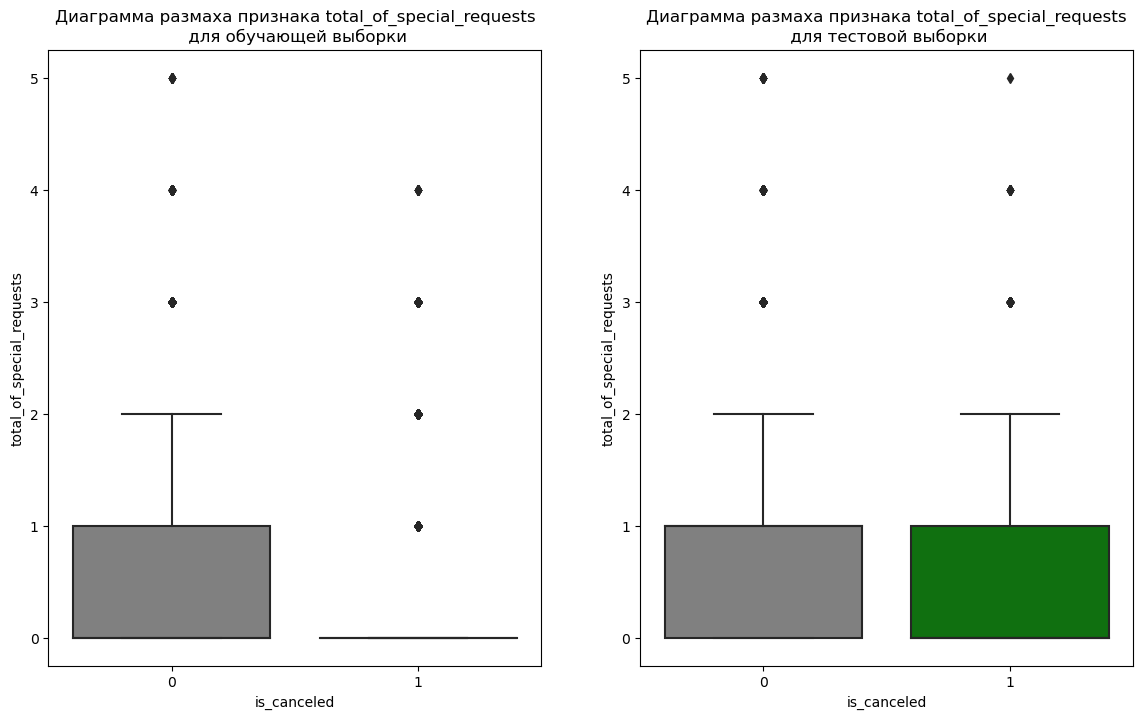

________________________________________________________________________________________________________________________


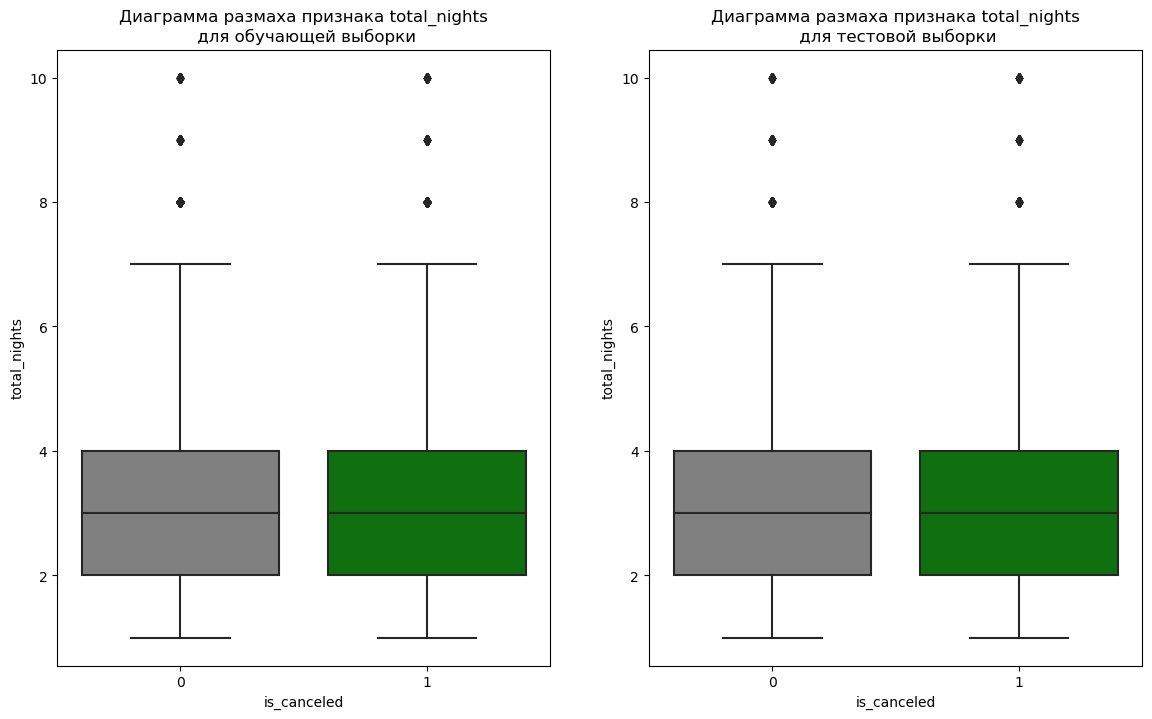

________________________________________________________________________________________________________________________


In [16]:
for i in df_train.columns:
    if (i not in object_list) & (i != 'is_canceled') & (i != 'arrival_date_year'):
        plt.figure(figsize=(14,8))
        ax = plt.subplot(1, 2, 1)
        ax = sns.boxplot(x='is_canceled', y=i, data=df_train, palette=sns.color_palette(('.5', 'g')))
        ax.set_title('Диаграмма размаха признака {}\n для обучающей выборки'.format(i))
        
        ax1 = plt.subplot(1, 2, 2)
        ax1 = sns.boxplot(x='is_canceled', y=i, data=df_test, palette=sns.color_palette(('.5', 'g')))
        ax1.set_title('Диаграмма размаха признака {}\n для тестовой выборки'.format(i))
        plt.show()
        print('_' * 120)

Диаграммы размаха подтверждают выводы, сделанные выше из гистограмм.  
Многие признаки имеют выбросы: у большинства клиентов схожие потребности и параметры заказов. Любое отклонение от параметров большинства может стать выбросом.

**Тепловые карты**

Во избежание негативного влияния выбросов и нелинейности взаимосвязей признаков для рассчета корреляции применяем коэффициент Спирмена.  
Строим тепловую карту признаков для обучающей выборки:

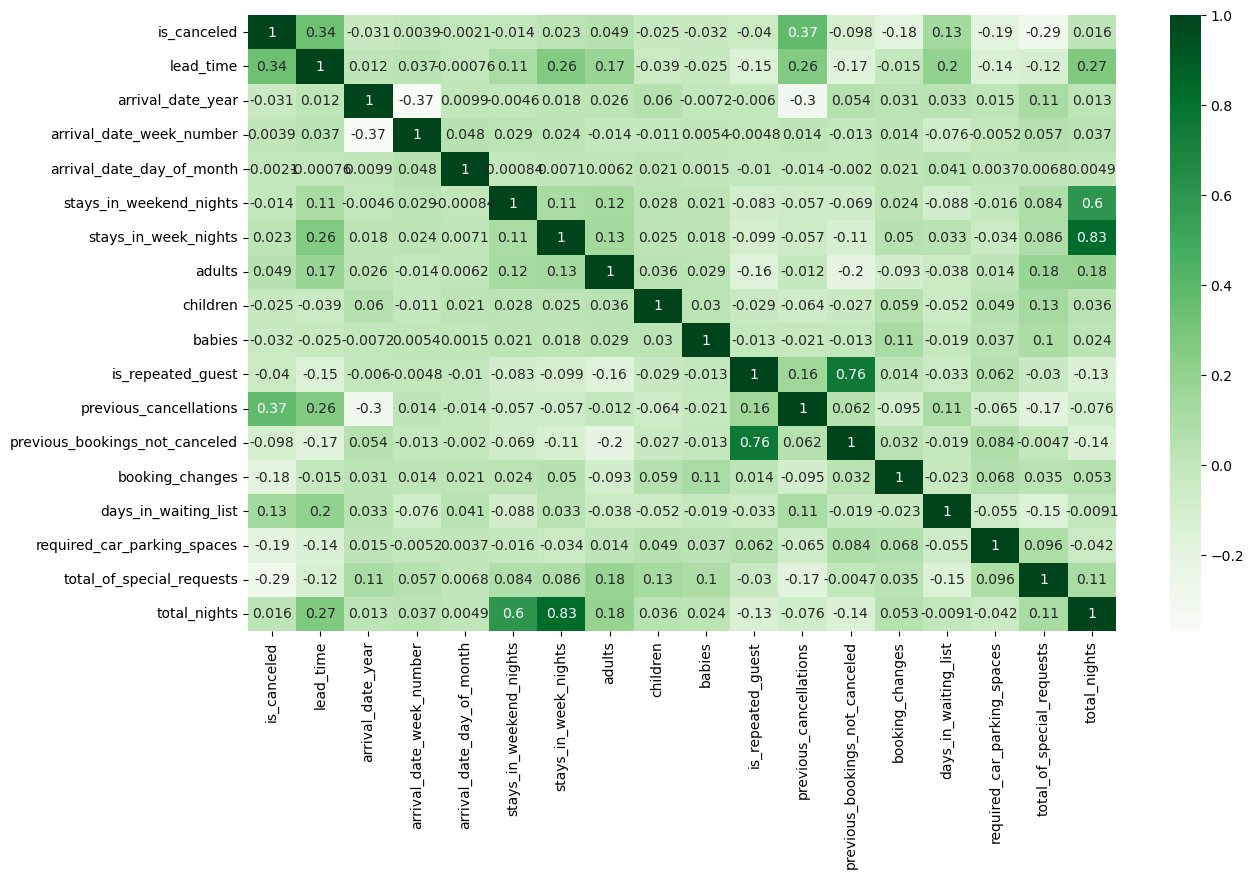

In [17]:
plt.figure(figsize=(14,8))
sns.heatmap(df_train.drop(object_list, axis=1).corr(method = 'spearman'), cmap="Greens", annot=True)
plt.show()

Наибольшая корреляция в тестовой выборке наблюдается между признаками:  
 - total_nights и stays_in_week_nights - 0.83;    
 - total_nights и stays_in_weekend_nights - 0.60.
 
С целевым признаком наиболее коррелируются признаки:
- previous_cancellations - 0.37;
- lead_time - 0.34.

Строим тепловую карту признаков для тестовой выборки на основе непараметрического критерия корреляции - коэффициента корреляции Спирмена:

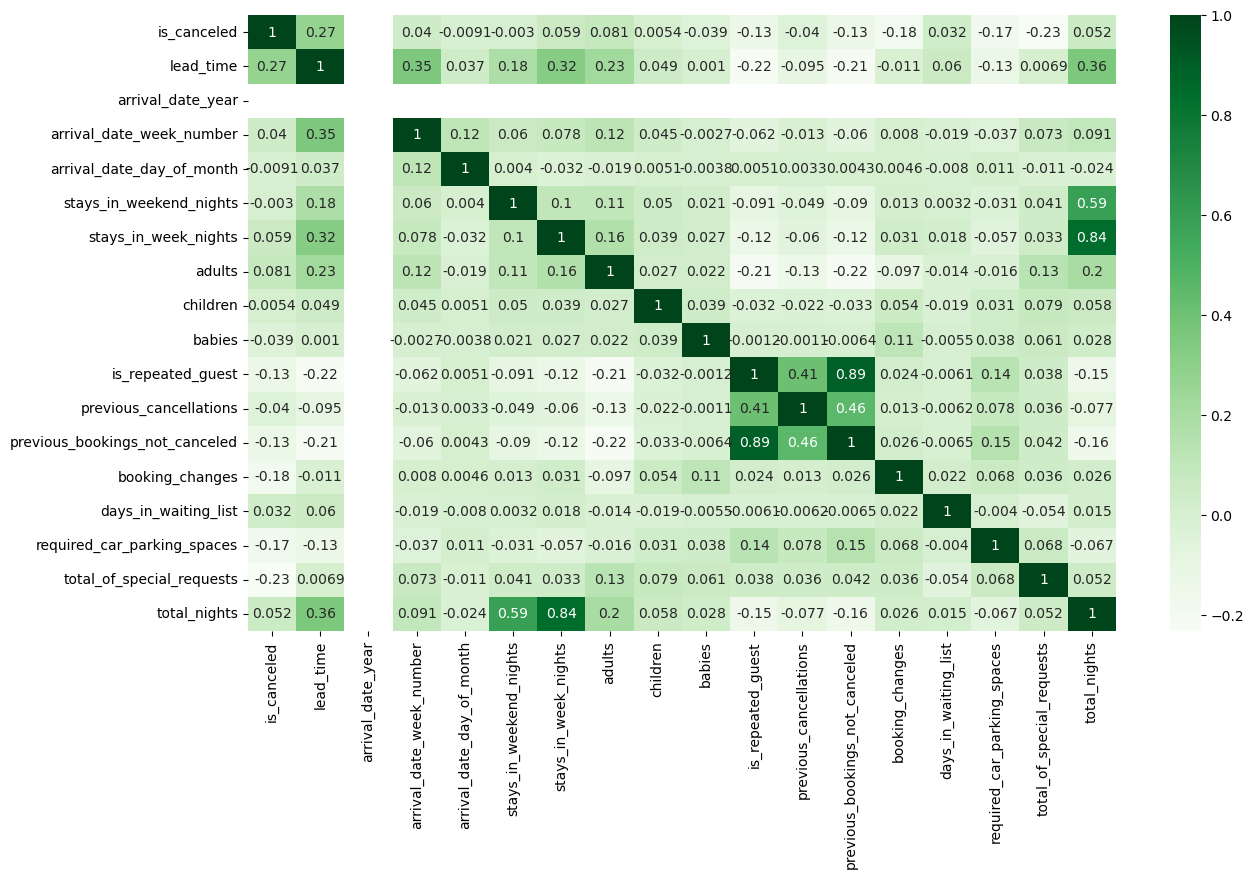

In [18]:
plt.figure(figsize=(14,8))
sns.heatmap(df_test.drop(object_list, axis=1).corr(method = 'spearman'), cmap="Greens", annot=True)
plt.show()

Наибольшая корреляция в тестовой выборке наблюдается между признаками:  
 - is_repeated_guest и previous_cancellations - 0.89;
 - total_nights и stays_in_week_nights - 0.84;   
 - total_nights и stays_in_weekend_nights - 0.59.
 
С целевым признаком наиболее коррелируются признаки:
 - lead_time - 0.27.

**Вывод:**  
1. Клиенты, не отменившие бронь, значительно чаще бронируют номера менее чем за месяц до заселения.  
Клиенты, отменившие бронь, в равной степени бронируют номера на срок от 0 до 365 дней до заселения.  
2. Во второй половине года (июль-декабрь) номера бронируются чаще, нежели в первой (январь-июнь). Пик количества бронирований приходится на сентябрь-октябрь, минимум - на январь.  
3. Наиболее часто номера бронируются на будние дни. Наиболее часто - на 1-3 будних дня.  
Клиенты, не отменившие бронь, чаще бронируют номер на один будний день.
Клиенты, отменившие бронь, чаще бронируют номер на два будних дня.  
4. Клиенты, как отменившие бронь, так и не отменившие, чаще бронируют номера на двух взрослых без детей и младенцев.  
5. Клиенты, как отменившие бронь, так и не отменившие, чаще оформляют бронь с включенным в заказ завтраком, реже всего - с завтраком, обедом и ужином.  
6. Наибольшее число клиентов - португальцы. При этом количество "отказников" среди них превышает количество надежных клиентов.  
7. Наиболее популярный канал дистрибуции заказа - "ta/to", наименее - "gds".
8. У большинства клиентов нет отменённых заказов и признаков повторного бронирования номера. За 2015-2016 годы около 5000 тысяч клиентов, отменивших бронь, ранее имели отмененные заказы.   
9. Наиболее часто бронируются самые дорогие номера - тип А.  
10. Заказы, как правило, подтверждаются в день оформления.  
11. Большинство заказов не связано с договором или групповым заездом.  
12. Многие признаки имеют выбросы: у большинства клиентов схожие потребности и параметры заказов. Любое отклонение от параметров большинства может стать выбросом.
13. Наибольшая корреляция в тестовой выборке наблюдается между признаками:  
 - total_nights и stays_in_week_nights - 0.83;  
 - total_nights и stays_in_weekend_nights - 0.60.  
 
С целевым признаком наиболее коррелируются признаки:  
- previous_cancellations - 0.37;  
- lead_time - 0.34.  
 
14. Наибольшая корреляция в тестовой выборке наблюдается между признаками:  
 - is_repeated_guest и previous_cancellations - 0.89;  
 - total_nights и stays_in_week_nights - 0.84;  
 - total_nights и stays_in_weekend_nights - 0.59.  
 
С целевым признаком наиболее коррелируются признаки:  
 - lead_time - 0.27.  

[Вернуться к содержанию](#start) 

## Вычисление бизнес-метрики
<a id="section_3"></a>

Рассчитываем количество забронированных дней по сезонам и прибыль без учета отмены брони:

In [19]:
def seasons(df, winter_ratio=0, spring_ratio=0.2, summer_ratio=0.4, autumn_ratio=0.2):
    '''Функция вычисления количества забронированных дней по сезонам и прибыли без учета отмены брони'''
    
    df['year'] = df['arrival_date_year']
    df['month'] = pd.to_datetime(df['arrival_date_month'], format= '%B').dt.strftime("%m")
    df['day'] = df['arrival_date_day_of_month']
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
    df['days_number'] = pd.DatetimeIndex(df['date']).days_in_month
    
    df.loc[df['arrival_date_month'].isin(['december', 'january']), 'winter'] = df['total_nights']
    df.loc[df['arrival_date_month'].isin(['march', 'april']), 'spring'] = df['total_nights']
    df.loc[df['arrival_date_month'].isin(['june', 'july']), 'summer'] = df['total_nights']
    df.loc[df['arrival_date_month'].isin(['september', 'october']), 'autumn'] = df['total_nights']
    
    df.loc[(df['arrival_date_month'] == 'february') & (df['arrival_date_day_of_month'] + df['arrival_date_day_of_month'] <= df['days_number']), 'winter'] = df['total_nights']
    df.loc[(df['arrival_date_month'] == 'february') & (df['arrival_date_day_of_month'] + df['arrival_date_day_of_month'] > df['days_number']), 'winter'] = df['days_number'] - df['arrival_date_day_of_month']
    df.loc[(df['arrival_date_month'] == 'february') & (df['arrival_date_day_of_month'] + df['arrival_date_day_of_month'] > df['days_number']), 'spring'] = df['total_nights'] + df['arrival_date_day_of_month'] - df['days_number']
    
    df.loc[(df['arrival_date_month'] == 'may') & (df['arrival_date_day_of_month'] + df['arrival_date_day_of_month'] <= df['days_number']), 'spring'] = df['total_nights']
    df.loc[(df['arrival_date_month'] == 'may') & (df['arrival_date_day_of_month'] + df['arrival_date_day_of_month'] > df['days_number']), 'spring'] = df['days_number'] - df['arrival_date_day_of_month']
    df.loc[(df['arrival_date_month'] == 'may') & (df['arrival_date_day_of_month'] + df['arrival_date_day_of_month'] > df['days_number']), 'summer'] = df['total_nights'] + df['arrival_date_day_of_month'] - df['days_number']
    
    df.loc[(df['arrival_date_month'] == 'august') & (df['arrival_date_day_of_month'] + df['arrival_date_day_of_month'] <= df['days_number']), 'summer'] = df['total_nights']
    df.loc[(df['arrival_date_month'] == 'august') & (df['arrival_date_day_of_month'] + df['arrival_date_day_of_month'] > df['days_number']), 'summer'] = df['days_number'] - df['arrival_date_day_of_month']
    df.loc[(df['arrival_date_month'] == 'august') & (df['arrival_date_day_of_month'] + df['arrival_date_day_of_month'] > df['days_number']), 'autumn'] = df['total_nights'] + df['arrival_date_day_of_month'] - df['days_number']
    
    df.loc[(df['arrival_date_month'] == 'november') & (df['arrival_date_day_of_month'] + df['arrival_date_day_of_month'] <= df['days_number']), 'autumn'] = df['total_nights']
    df.loc[(df['arrival_date_month'] == 'november') & (df['arrival_date_day_of_month'] + df['arrival_date_day_of_month'] > df['days_number']), 'autumn'] = df['days_number'] - df['arrival_date_day_of_month']
    df.loc[(df['arrival_date_month'] == 'november') & (df['arrival_date_day_of_month'] + df['arrival_date_day_of_month'] > df['days_number']), 'winter'] = df['total_nights'] + df['arrival_date_day_of_month'] - df['days_number']
    
    df['winter'] = df['winter'] * (1 + winter_ratio)
    df['spring'] = df['spring'] * (1 + spring_ratio)
    df['summer'] = df['summer'] * (1 + summer_ratio)
    df['autumn'] = df['autumn'] * (1 + autumn_ratio)
    df[['winter', 'spring', 'summer', 'autumn']] = df[['winter', 'spring', 'summer', 'autumn']].fillna(0)
    
    
    price_dict = {'a' : 1000, 'b' : 800, 'c' : 600, 'd' : 550, 'e' : 500, 'f' : 450, 'g' : 360}
    expenses_dict = {'a' : 400, 'b' : 350, 'c' : 350, 'd' : 150, 'e' : 150, 'f' : 150, 'g' : 150}
    
    
    for i in df['reserved_room_type'].unique():
        df.loc[df['reserved_room_type'] == i, 'price_day'] = price_dict[i]
        df.loc[df['reserved_room_type'] == i, 'expens_day'] = expenses_dict[i]
        df.loc[df['reserved_room_type'] == i, 'price'] = (df['winter'] + df['spring'] + df['summer'] + df['autumn']) * df['price_day']
        df.loc[(df['reserved_room_type'] == i) & (df['total_nights'] <= 2), 'expenses'] = (df['winter'] + df['spring'] + df['summer'] + df['autumn']) * df['expens_day']
        df.loc[(df['reserved_room_type'] == i) & (df['total_nights'] > 2), 'expenses'] = ((df['winter'] + df['spring'] + df['summer'] + df['autumn']) / 2) * df['expens_day']
        df.loc[df['reserved_room_type'] == i, 'profit'] = df['price'] - df['expenses']

    df = df.drop(['winter', 'spring', 'summer', 'autumn', 'year', 'month', 'day', 'date', 'days_number',
                 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month'], axis=1)
    return df

In [20]:
df_train = seasons(df_train)
df_test = seasons(df_test)

На тестовой выборке рассчитываем прибыль с учетом отмены бронирования без депозита:

In [21]:
def prft(df):
    '''функция расчёта прибыли с учетом отмены бронирования без депозита'''
    deposit_koef = 0.8
    df_prft = df.copy()
    if 'predict_t' not in df_prft.columns:
        df_prft.loc[df_prft['is_canceled'] == 1, 'profit'] = - df_prft['price_day'] - df_prft['expens_day']
    else:
        df_prft.loc[(df_prft['is_canceled'] == 1) & (df_prft['predict_t'] != 1), 'profit'] =\
        - df_prft['price_day'] - df_prft['expens_day']
        
        df_prft.loc[(df_prft['is_canceled'] == 1) & (df_prft['predict_t'] == 1), 'profit'] =\
        (deposit_koef - 1) * (df_prft['price_day'] + df_prft['expens_day'])
    df_prft = df_prft.drop(['price_day', 'expens_day', 'price', 'expenses'], axis=1)
    return df_prft['profit']

In [22]:
series_no_deposit = prft(df_test)
print('Общая прибыль с учетом отмены бронирования без списания депозита: {:.2f} млн.'.format(series_no_deposit.sum() / 1000000))

Общая прибыль с учетом отмены бронирования без списания депозита: 34.20 млн.


**Вывод:**  
Общая прибыль на тестовой выборке с учетом отмены бронирования без списания депозита: 34.20 млн.

[Вернуться к содержанию](#start) 

## Разработка модели ML
<a id="section_4"></a>

Задаем общий для всех моделей параметр random_state:

In [23]:
RS = 42

### Подготовка данных
<a id="section_4_1"></a>

**Функции подготовки данных**

Создаем списки категориальных и количественных признаков:

In [24]:
categorical_features = ['arrival_date_month','meal', 'country', 'distribution_channel', 'is_repeated_guest',
                        'reserved_room_type', 'customer_type']
numerical_features = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies',
                      'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes',
                      'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests', 'total_nights']

Выделяем из выборок целевой признак. Из признаков удаляем данные, добавленные для расчёта прибыли, и данные по году, номеру недели и дню месяца бронирования: год для прогнозирования не пригоден, т.к. 2015 и 2016 более не повторяться, а недели и дни - слишком малые временные периоды, где велика доля случайности. Для прогнозирования оставляем временной период в месяц.

In [25]:
def separation(df):
    '''Функция разделения датафреймов на признаки и целевой признак'''
    features = df.drop(['price_day', 'expens_day', 'is_canceled', 'price', 'expenses', 'profit'], axis=1)
    target = df['is_canceled']
    return features, target

In [26]:
X_train, y_train = separation(df_train)
X_test, y_test = separation(df_test)

Создаем трансформер входных признаков - OneHotEncoder и StandardScaler:

In [27]:
OHE = OneHotEncoder(handle_unknown='ignore', drop='first')
scaler = StandardScaler()
transformer = ColumnTransformer([
    ('categorical_features', OHE, categorical_features),
    ('numerical_features', scaler, numerical_features)])

Проверяем обучающую выборку на дисбаланс классов:

In [28]:
positive_share = y_train.mean()
print('Доля положительных значений целевого признака: {:.2f}.'.format(positive_share))

Доля положительных значений целевого признака: 0.37.


### Построение моделей и определение лучшей
<a id="section_4_2"></a>

**Функции построения моделей**

In [29]:
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state=RS)

Гиперпараметры подбираются с помощью OptunaSearchCV.  
Лучшую модель определяем по метрике ROC-AUC. Поскольку метрика не восприимчива к дисбалансу классов, балансировку не проводим. Вместо балансировки классов находим оптимальный порог и производим предсказание с учетом его.  
В целях определения качества определения каждого из классов дополнительно рассчитываем метрики F1 и Recall.

In [30]:
def metrics(model, params, model_name):
    '''функция обучения моделей и расчёта метрик'''
    
    optuna.logging.set_verbosity(optuna.logging.WARNING)                               # отключаем логгирование
    model = OptunaSearchCV(model, params, scoring='roc_auc', cv=skf)                     # передаем данные в OptunaSearchCV
    start_time = timeit.default_timer()                                                # начальное время обучения
    model.fit(X_train, y_train)                                                        # обучаем модель
    time_fit = timeit.default_timer() - start_time                                     # длительность обучения
    start_time = timeit.default_timer()                                                # начальное время предсказания
    
    roc_auc = model.best_score_                                                        # метрика roc_auc
    y_pred = model.best_estimator_.predict(X_train)                                    # делаем предсказание
    time_pred = timeit.default_timer() - start_time                                    # длительность предсказания
    
    recall = recall_score(y_train, y_pred).round(3)                                    # метрика recall
    f1 = f1_score(y_train, y_pred).round(3)                                            # метрика f1
    accuracy = accuracy_score(y_train, y_pred).round(3) 
    
    print('ROC_AUC: {}'.format(roc_auc))                                               # выводим метрику roc_auc
    print('Recall: {}'.format(recall))                                                 # выводим метрику recall
    print('F1: {}'.format(f1))                                                         # выводим метрику f1
    print('Accuracy: {}'.format(accuracy))                                             # выводим метрику accuracy
    
    return model, accuracy, recall, roc_auc, f1, time_fit, time_pred

**Модель LogisticRegression**

Задаем сетку гиперпораметров и модель:

In [31]:
params_lr = {'C': intd(1, 10, False, 1)}                             # значения гиперпараметров модели для подбора
new_params_lr = {'model_lr__' + key: params_lr[key] for key in params_lr}
model_lr = LogisticRegression(max_iter=1000, random_state=RS)        # создаем модель

Создаем пайплайн предобработки данных и обучаемой модели:

In [32]:
pipeline_lr = Pipeline([("preprocessing", transformer),
                    ("model_lr", model_lr)])

Обучаем модель:

In [33]:
%%capture --no-stdout
best_model_lr, accuracy_lr, recall_lr, roc_auc_lr, f1_lr, time_fit_lr, time_pred_lr = metrics(pipeline_lr,
                                                                                              new_params_lr,
                                                                                              'LogisticRegression')

ROC_AUC: 0.8730184606060785
Recall: 0.646
F1: 0.712
Accuracy: 0.807


**Модель DecisionTreeClassifier**

Задаем сетку гиперпораметров и модель:

In [34]:
params_dtc = {'min_samples_leaf' : intd(1, 10, False, 1),         # значения гиперпараметров модели для подбора
              'min_samples_split' : intd(2, 10, False, 1),
              'max_depth' : intd(1, 10, False, 1)}
new_params_dtc = {'model_dtc__' + key: params_dtc[key] for key in params_dtc}
model_dtc = DecisionTreeClassifier(random_state=RS)               # создаем модель

Создаем пайплайн предобработки данных и обучаемой модели:

In [35]:
pipeline_dtc = Pipeline([("preprocessing", transformer),
                    ("model_dtc", model_dtc)])

Обучаем модель:

In [36]:
%%capture --no-stdout
best_model_dtc, accuracy_dtc, recall_dtc, roc_auc_dtc, f1_dtc, time_fit_dtc, time_pred_dtc = metrics(pipeline_dtc,
                                                                                                     new_params_dtc,
                                                                                                     'DecisionTreeClassifier')

ROC_AUC: 0.9037453158884569
Recall: 0.707
F1: 0.761
Accuracy: 0.836


**Модель RandomForestClassifier**

Задаем сетку гиперпораметров и модель:

In [37]:
params_rfc = {'min_samples_leaf' : intd(1, 10, False, 1),             # значения гиперпараметров модели для подбора
              'min_samples_split' : intd(2, 10, False, 1),
              'max_depth' : intd(1, 10, False, 1),
              'n_estimators' : intd(100, 150, False, 10)}
new_params_rfc = {'model_rfc__' + key: params_rfc[key] for key in params_rfc}
model_rfc = RandomForestClassifier(random_state=RS)                   # создаем модель

Создаем пайплайн предобработки данных и обучаемой модели:

In [38]:
pipeline_rfc = Pipeline([("preprocessing", transformer),
                    ("model_rfc", model_rfc)])

Обучаем модель:

In [39]:
%%capture --no-stdout
best_model_rfc, accuracy_rfc, recall_rfc, roc_auc_rfc, f1_rfc, time_fit_rfc, time_pred_rfc = metrics(pipeline_rfc,
                                                                                                     new_params_rfc,
                                                                                                     'RandomForestClassifier')

ROC_AUC: 0.9018293510829161
Recall: 0.538
F1: 0.679
Accuracy: 0.812


**Модель CatBoostClassifier**

Задаем сетку гиперпораметров и модель:

In [40]:
params_cb = {                                                         # значения гиперпараметров модели для подбора
    'depth' : intd(5, 10, False, 1),
}
model_cb = CatBoostClassifier(verbose=False,                          # создаем модель
                              iterations = 1000,
                              cat_features=categorical_features,
                              task_type="GPU",
                              random_state=RS)

Обучаем модель:

In [41]:
best_model_cb, accuracy_cb, recall_cb, roc_auc_cb, f1_cb, time_fit_cb, time_pred_cb = metrics(model_cb,
                                                                                              params_cb,
                                                                                              'CatBoostClassifier')

C:\Users\bond_\AppData\Local\Temp\ipykernel_48280\719991946.py:5: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  model = OptunaSearchCV(model, params, scoring='roc_auc', cv=skf)                     # передаем данные в OptunaSearchCV


ROC_AUC: 0.9399904184159549
Recall: 0.813
F1: 0.859
Accuracy: 0.902


**Сравнение моделей**

Сравнительная таблица:

In [42]:
# собираем таблицу
df_best_model = pd.DataFrame({'model' : ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier', 'CatBoostClassifier'],
                              'accuracy' : [accuracy_lr, accuracy_dtc, accuracy_rfc, accuracy_cb],
                              'recall' : [recall_lr, recall_dtc, recall_rfc, recall_cb],
                              'f1' : [f1_lr, f1_dtc, f1_rfc, f1_cb],
                              'roc_auc' : [roc_auc_lr, roc_auc_dtc, roc_auc_rfc, roc_auc_cb],
                              'time_fit' : [time_fit_lr, time_fit_dtc, time_fit_rfc, time_fit_cb],
                              'time_pred' : [time_pred_lr, time_pred_dtc, time_pred_rfc, time_pred_cb],
                              'best_model' : [best_model_lr, best_model_dtc, best_model_rfc, best_model_cb]})
df_best_model[['model', 'accuracy', 'recall', 'f1', 'roc_auc', 'time_fit', 'time_pred']]                # выводим таблицу

,model,accuracy,recall,f1,roc_auc,time_fit,time_pred
0,LogisticRegression,0.807,0.646,0.712,0.873018,70.072963,0.115978
1,DecisionTreeClassifier,0.836,0.707,0.761,0.903745,17.213804,0.122837
2,RandomForestClassifier,0.812,0.538,0.679,0.901829,157.503089,0.644590
3,CatBoostClassifier,0.902,0.813,0.859,0.939990,2227.260260,0.228668


Выделяем из таблицы модель с наибольшим ROC-AUC:

In [43]:
best_model_row = df_best_model.loc[df_best_model['roc_auc'] == df_best_model['roc_auc'].max()]
best_model = best_model_row.iloc[0, 7]
best_model_name = best_model_row.iloc[0, 0]
best_model_params = best_model_row.iloc[0, 7].best_params_

In [44]:
print('Лучшая модель: {}'.format(best_model_name))
print('Параметры лучшей модели: {}'.format(best_model_params))

Лучшая модель: CatBoostClassifier
Параметры лучшей модели: {'depth': 10}


**Важность основных факторов**

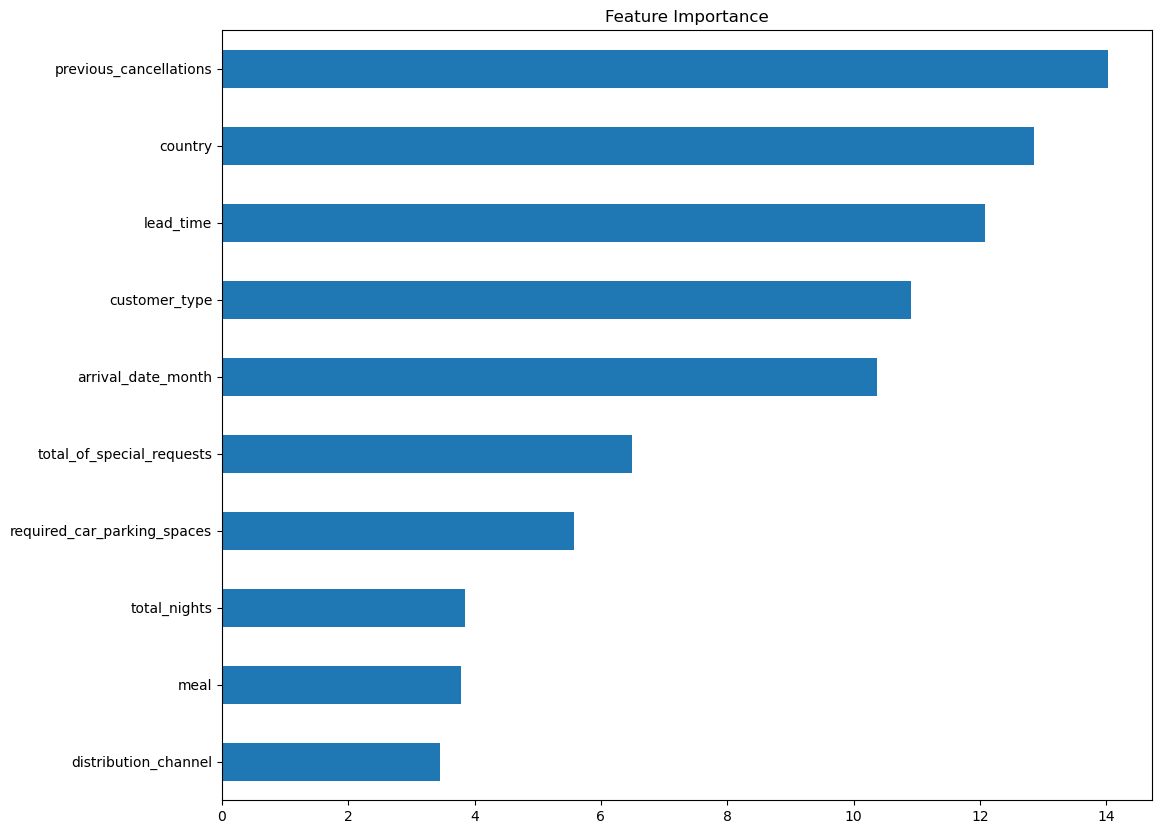

In [45]:
if best_model_name == 'CatBoostClassifier':
    importance = best_model.best_estimator_.feature_importances_           # получаем коэффициенты важности признаков
elif best_model_name == 'LogisticRegression':
    importance = best_model_lr.best_estimator_._final_estimator.coef_[0]   # получаем коэффициенты важности признаков
else:
    # получаем коэффициенты важности признаков
    importance = best_model_rfc.best_estimator_._final_estimator.feature_importances_
# создаем датафрейм из 10 важнейших признаков
importance_features = pd.Series(importance, index=X_train.columns).sort_values(ascending=True).tail(10)
plt.figure(figsize=(12,10))                                                # задаем размер окна диаграммы
importance_features.plot(kind='barh',title = 'Feature Importance')         # визуализируем диаграмму
plt.show()

**Вывод:**  

Рассмотрены модели LogisticRegression, DecisionTreeClassifier, RandomForestClassifier и CatBoostClassifier.  
Модель с наибольшим значением F1 - CatBoostClassifier.  
Метрики лучшей модели:  
 - accuracy: 0.902;  
 - recall: 0.813;  
 - f1: 0.859;  
 - roc_auc: 0.940;  
 - время обучения (секунд): 2227.26;  
 - время предсказания (секунд): 0.229.  
 
Параметры лучшей модели:  
 - depth - 10.  
 
Наиболее важный признак - количество отменённых заказов.

[Вернуться к содержанию](#start) 

## Проверка на тестовой выборке
<a id="section_5"></a>

**Расчёт метрик лучшей модели на тестовой выборке**

Находим оптимальный порог и визуализируем ROC Curve:

In [46]:
y_pred = best_model.predict(X_test)

Best Threshold=0.216891, G-Mean=0.744


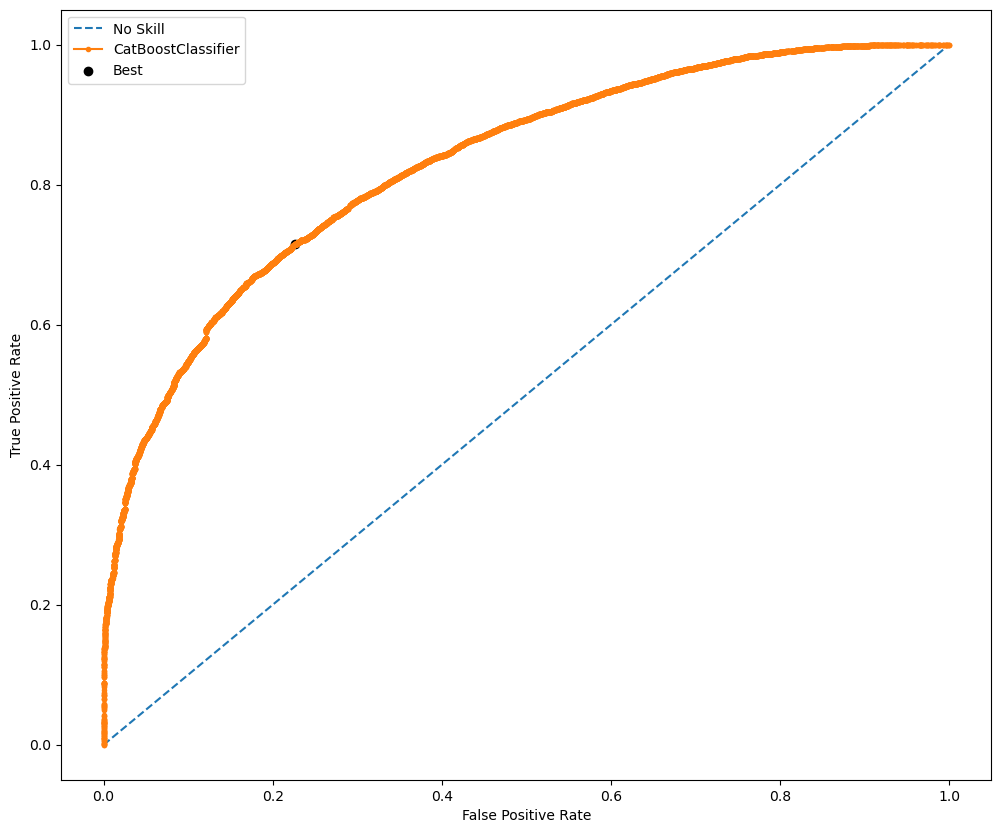

In [47]:
yhat = best_model.predict_proba(X_test)
yhat = yhat[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, yhat)
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
plt.figure(figsize=(12,10)) 
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label=best_model_name)
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Получаем предсказанния целевой переменной с учетом оптимального порога:

In [48]:
y_pred_optimal = np.where(yhat < thresholds[ix], 0, 1)

Рассчитываем метрики на тестовой выборке:

In [49]:
roc_auc = roc_auc_score(y_test, y_pred_optimal)
recall = recall_score(y_test, y_pred_optimal)
f1 = f1_score(y_test, y_pred_optimal)
accuracy = accuracy_score(y_test, y_pred_optimal)
print('ROC-AUC: {:.3f}'.format(roc_auc))
print('Recall: {:.3f}'.format(recall))
print('F1: {:.3f}'.format(f1))
print('Accuracy: {:.3f}'.format(accuracy))

Roc-Auc: 0.745
Recall: 0.715
F1: 0.691
Accuracy: 0.751


**Матрица ошибок**

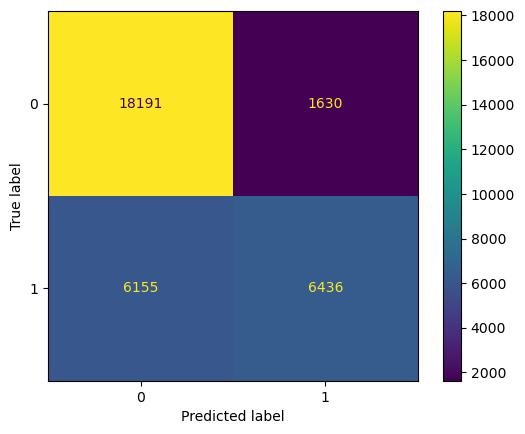

In [50]:
cm = confusion_matrix(y_test, y_pred)                                           # рассчитываем матрицу ошибок
disp = ConfusionMatrixDisplay(confusion_matrix=cm)                              
disp.plot()                                                                     # визуализируем матрицу ошибок
plt.show()

**Проверка модели на адекватность**

In [51]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=RS)
dummy_clf.fit(X_test, y_test)
dummy_accuracy = dummy_clf.score(X_test, y_test)
if accuracy > dummy_accuracy:
    print('Accuracy для выбранной модели ({:.3f}) выше, чем accuracy для "наивного" алгоритма ({:.3f}), модель можно считать адекватной.'
          .format(accuracy, dummy_accuracy))
else:
    print('Accuracy для выбранной модели ({:.3f}) не выше, чем accuracy для "наивного" алгоритма ({:.3f}),\n модель нельзя считать адекватной.'
          .format(accuracy, dummy_accuracy))

Accuracy для выбранной модели (0.751) выше, чем accuracy для "наивного" алгоритма (0.612), модель можно считать адекватной.


**Вывод:**  
Метрики лучшей модели на тестовой выборке:
 - ROC-AUC: 0.745;
 - Recall: 0.715;
 - F1: 0.691;
 - Accuracy: 0.751; 
 
Accuracy для выбранной модели (0.751) выше, чем accuracy для "наивного" алгоритма (0.612), модель можно считать адекватной.

[Вернуться к содержанию](#start) 

## Прогноз прибыли
<a id="section_6"></a>

Рассчитываем прибыль на основе прогноза с учетом использования депозита:

In [52]:
df_test['predict_t'] = y_pred

In [53]:
series_deposit = prft(df_test)
print('Общая прибыль с учетом отмены бронирования и списания депозита: {:.2f} млн.'.format(series_deposit.sum() / 1000000))

Общая прибыль с учетом отмены бронирования и списания депозита: 40.73 млн.


Рассчитываем прирост прибыли при использовании депозита:

In [54]:
deposit_delta = series_deposit.sum() - series_no_deposit.sum()
print('Прирост прибыли при использовании депозита: {:.2f} млн.'.format(deposit_delta / 1000000))

Прирост прибыли при использовании депозита: 6.52 млн.


In [55]:
EXPENSES = 400000
if deposit_delta > EXPENSES:
    print('Прирост прибыли от внедрения системы превышает затраты на {:.3f} млн.'.format((deposit_delta - EXPENSES) / 1000000))
else:
    print('Затраты на внедрение системы превышают прирост прибыли на {:.3f} млн.'.format((EXPENSES - deposit_delta) / 1000000))

Прирост прибыли от внедрения системы превышает затраты на 6.124 млн.


### Проверка гипотезы об увеличении прибыли
<a id="section_6_1"></a>

Формулируем гипотезу (одностороннюю):

***Гипотеза H0: прибыль при использовании депозита не превышает прибыль без использования депозита  
Гипотеза H1: прибыль при использовании депозита превышает прибыль без использования депозита***

Задаем критический уровень статистической значимости:

In [56]:
alpha = .01

Сравниваем дисперсии выборок тестом Левена:

In [57]:
var_profit = levene(series_deposit, series_no_deposit)

if var_profit.pvalue / 2 < alpha:
    eq_var = True
    print('Значение pvalue ({}) не превышает критический уровень статистической значимости - выборки не имеют одинаковой дисперсии.'
          .format(var_profit.pvalue / 2))
else:
    eq_var = False
    print('Значение pvalue ({}) превышает критический уровень статистической значимости - выборки имеют одинаковую дисперсию.'
          .format(var_profit.pvalue / 2))

Значение pvalue (9.169616085797555e-79) не превышает критический уровень статистической значимости - выборки не имеют одинаковой дисперсии.


Сравниваем выборки (t-тест):

In [58]:
result_profit = st.ttest_ind(series_deposit, series_no_deposit, equal_var = eq_var)
print('pvalue:', result_profit.pvalue / 2)

pvalue: 1.0681474942333699e-30


Проверяем нулевую гипотезу:

In [59]:
if result_profit.pvalue / 2 < alpha and series_deposit.mean() > series_no_deposit.mean():
    print('Отвергаем нулевую гипотезу: с высокой вероятностью прибыль с использованием депозита больше, чем без него.')
else:
    print('Не отвергаем нулевую гипотезу: с высокой вероятностью прибыль с использованием депозита не больше, чем без него.')

Отвергаем нулевую гипотезу: с высокой вероятностью прибыль с использованием депозита больше, чем без него.


**Вывод:**
1. Прирост прибыли при использовании депозита: 6.785 млн.  
5. По результатам t-теста установлено, что с высокой вероятностью прибыль с использованием депозита больше, чем без него.

[Вернуться к содержанию](#start) 

## Признаки «ненадёжного» клиента
<a id="section_7"></a>

Находим медианные значения числовых признаков:

In [60]:
bad_client = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies',
              'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes',
              'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests', 'total_nights']

In [61]:
print('Медианные значения числовых признаков:')
for i in bad_client:
    print('{} - {}'.format(i, df_test.loc[df_test['is_canceled'] == 1][i].median()))

Медианные значения числовых признаков:
lead_time - 111.0
stays_in_weekend_nights - 1.0
stays_in_week_nights - 2.0
adults - 2.0
children - 0.0
babies - 0.0
is_repeated_guest - 0.0
previous_cancellations - 0.0
previous_bookings_not_canceled - 0.0
booking_changes - 0.0
days_in_waiting_list - 0.0
required_car_parking_spaces - 0.0
total_of_special_requests - 0.0
total_nights - 3.0


**Вывод:** 
У ненадежного клиента:
 - гражданство Португалии;
 - медианное значение количества дней от даты бронирования до заселения - 111 дней;
 - количество ночей на выходных - 1;
 - количество ночей в неделю - 2;
 - бронь на двух взрослых без детей и младенцев;
 - чаще всего заказ с включенным в заказ завтраком, реже всего - с завтраком, обедом и ужином;
 - наиболее популярный канал дистрибуции заказа - "ta/to", наименее - "gds";
 - наиболее часто бронируются самые дорогие номера - тип А;
 - Большинство заказов не связано с договором или групповым заездом

В зоне риска - граждане Португалии, бронирующие номер более чем за месяц до заселения.

[Вернуться к содержанию](#start) 

## Общий вывод
<a id="section_8"></a>

**Импорт данных и общая информация**  
В обучающей выборке:  
 - 65229 строк и 25 признаков. Пропущенные значения отсутствуют;  
 - данные за 2015-2016 годы;  
 - Максимальное значение признака babies - 10 (количество младенцев), что маловероятно в реальности;
 - Запись значений признаков meal и reserved_room_type некорректны: присутствуют лишние пробелы.

В тестовой выборке:
 - В датафрейме 32412 строк и 25 признаков. Пропущенные значения отсутствуют;   
 - В датафрейме приведены данные за январь-август 2017 года;
 - Запись значений признаков meal и reserved_room_type некорректны: присутствуют лишние пробелы.
 

**Предобработка и исследовательский анализ данных**  
1. Удалены выбросы признака babies обучающей выборки;  
2. обработаны строковые значения;  
3. преобразованы типы данных;  
4. Клиенты, не отменившие бронь, значительно чаще бронируют номера менее чем за месяц до заселения.  
Клиенты, отменившие бронь, в равной степени бронируют номера на срок от 0 до 365 дней до заселения.  
5. Во второй половине года (июль-декабрь) номера бронируются чаще, нежели в первой (январь-июнь). Пик количества бронирований приходится на сентябрь-октябрь, минимум - на январь.  
6. Наиболее часто номера бронируются на будние дни. Наиболее часто - на 1-3 будних дня.  
Клиенты, не отменившие бронь, чаще бронируют номер на один будний день.
Клиенты, отменившие бронь, чаще бронируют номер на два будних дня.  
7. Клиенты, как отменившие бронь, так и не отменившие, чаще бронируют номера на двух взрослых без детей и младенцев.  
8. Клиенты, как отменившие бронь, так и не отменившие, чаще оформляют бронь с включенным в заказ завтраком, реже всего - с завтраком, обедом и ужином.  
9. Наибольшее число клиентов - португальцы. При этом количество "отказников" среди них превышает количество надежных клиентов.  
10. Наиболее популярный канал дистрибуции заказа - "ta/to", наименее - "gds".
11. У большинства клиентов нет отменённых заказов и признаков повторного бронирования номера. За 2015-2016 годы около 5000 тысяч клиентов, отменивших бронь, ранее имели отмененные заказы.   
12. Наиболее часто бронируются самые дорогие номера - тип А.  
13. Заказы, как правило, подтверждаются в день оформления.  
14. Большинство заказов не связано с договором или групповым заездом.  
15. Многие признаки имеют выбросы: у большинства клиентов схожие потребности и параметры заказов. Любое отклонение от параметров большинства может стать выбросом.
16. Наибольшая корреляция в тестовой выборке наблюдается между признаками:  
 - total_nights и stays_in_week_nights - 0.83;    
 - total_nights и stays_in_weekend_nights - 0.60.
 
С целевым признаком наиболее коррелируются признаки:
- previous_cancellations - 0.37;
- lead_time - 0.34.
 
17. Наибольшая корреляция в тестовой выборке наблюдается между признаками:  
 - is_repeated_guest и previous_cancellations - 0.89;
 - total_nights и stays_in_week_nights - 0.84;   
 - total_nights и stays_in_weekend_nights - 0.59.
 
С целевым признаком наиболее коррелируются признаки:
 - lead_time - 0.27.
 
 
**Вычисление бизнес-метрики**  
Общая прибыль на тестовой выборке с учетом отмены бронирования без списания депозита: 34.20 млн.  


**Построение моделей и определение лучшей**  

Рассмотрены модели LogisticRegression, DecisionTreeClassifier, RandomForestClassifier и CatBoostClassifier.  
Модель с наибольшим значением F1 - CatBoostClassifier.  
Метрики лучшей модели:  
 - accuracy: 0.902;  
 - recall: 0.813;  
 - f1: 0.859;  
 - roc_auc: 0.940;  
 - время обучения (секунд): 2227.26;  
 - время предсказания (секунд): 0.229.  
 
Параметры лучшей модели:  
 - depth - 10.  
 
Наиболее важный признак - количество отменённых заказов.


**Проверка на тестовой выборке**  

Метрики лучшей модели на тестовой выборке:
 - ROC-AUC: 0.745;
 - Recall: 0.715;
 - F1: 0.691;
 - Accuracy: 0.751; 
 
Accuracy для выбранной модели (0.751) выше, чем accuracy для "наивного" алгоритма (0.612), модель можно считать адекватной.

Важнейшими признаками являются:
- previous_cancellations — количество отменённых заказов у клиента; 
- country — гражданство постояльца;
- lead_time — количество дней между датой бронирования и датой прибытия. 


**Прогноз прибыли**  

Прирост прибыли от внедрения системы превышает затраты на 6.124 млн.


**Признаки «ненадёжного» клиента**  
У ненадежного клиента:  
- гражданство Португалии;  
- медианное значение количества дней от даты бронирования до заселения - 111 дней;  
- количество ночей на выходных - 1;  
- количество ночей в неделю - 2;  
- бронь на двух взрослых без детей и младенцев;
- чаще всего заказ с включенным в заказ завтраком, реже всего - с завтраком, обедом и ужином;  
- наиболее популярный канал дистрибуции заказа - "ta/to", наименее - "gds";  
- наиболее часто бронируются самые дорогие номера - тип А;  
- Большинство заказов не связано с договором или групповым заездом. 
 
В зоне риска - граждане Португалии, бронирующие номер более чем за месяц до заселения.

[Вернуться к содержанию](#start) 